# Preamble

This notebook contains some work related to the paper *HATS-19b, HATS-20b, HATS-21b: three hot-Saturns from the HATSouth survey* by Bhatti et al. (2016).

## Contents

- Preamble:
  - <a href="#Python-requirements">Requirements</a>
  - <a href="#Data-files">Data files</a>
  - <a href="#Python-imports-and-setup">Importing required modules and setting up functions</a>
- Paper work: 
  - <a href="#Bisector-span-vs.-RV-correlations">Bisector span vs. RV correlations</a>
  - <a href="#Contrast-curves-from-lucky-imaging">Contrast curves from lucky-imaging</a>
  - <a href="#Stellar-variability">Looking for stellar variability</a>
  - <a href="#Mass-radius-plot">Mass-radius plot for transiting giant planets</a>
  - <a href="#Radius-Teq-FEH-correlations">Correlations between giant planet radius and $T_{\mathrm{eq}}$ and [Fe/H]</a>
  - <a href="#Random-forest-regression">Random forest regression models for giant planet classes</a>

## Python requirements

This notebook requires the following modules:

- numpy (http://www.numpy.org/)
- scipy (http://scipy.org/scipylib/index.html)
- matplotlib (http://matplotlib.org/)
- Jupyter and IPython (http://ipython.org/)
- scikit-learn (http://www.scikit-learn.org)

The best way to get all of these if you don't have them installed already is probably via the `anaconda` Python distribution: https://www.continuum.io/downloads.

In addition, some things in this notebook require modules that I've included in this repository:

- `hatlc.py`: to read new-format HAT LCs
- `oldhatlc.py`: to read older-format HAT LCs (like those from http://hatnet.org or http://hatsouth.org)
- `periodbase.py`: some functions to run period-finding algorithms
- `glsp.py`: a parallelized Generalized-Lomb-Scargle implementation
- `varbase.py`: some functions to calculate variability metrics and manipulate LCs
- `plotbase.py`: some functions to plot LCs
- `fortney2k7.py`: planet models from <a href="http://adsabs.harvard.edu/abs/2007ApJ...659.1661F">Fortney et al. (2007)</a> in an importable Python dict for convenience

## Data files

The following data files should be included along with this repository:

- `planet-mass-radius-with-errors.csv`: CSV file containing transiting planet info from http://exoplanets.org, last updated on 2016-04-12.
- `HATS-19b-hatlc.csv.gz`: the HATSouth light curve for HATS-19b.
- `HATS-20b-old-hatlc.csv.gz`: the HATSouth light curve for HATS-20b.
- `HATS-21b-old-hatlc.csv.gz`: the HATSouth light curve for HATS-21b.

## Python imports and setup

In [26]:
##################
## IMPORT STUFF ##
##################

import cPickle as pickle
import periodbase, plotbase, varbase, hatlc, oldhatlc
from scipy import stats
from numpy import random
import fortney2k7
import pyfits

from scipy import interpolate
from matplotlib.ticker import ScalarFormatter # use to get scientific notation
from matplotlib.colors import LogNorm

from sklearn.ensemble import RandomForestRegressor
from operator import itemgetter
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint

#######################
## SET UP MATPLOTLIB ##
#######################

import matplotlib

# use tex for all plot text
matplotlib.rc('text', usetex=True)

# use the times font to match the paper's font
# if this is commented out, will use the default Computer Modern font
matplotlib.rc('font',**{'family':'serif','serif':['Times']})

# fonts for the entire thing
matplotlib.rcParams['font.size'] = 16

# lines
matplotlib.rcParams['lines.linewidth'] = 2.0

# axes
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.labelsize'] = 'large'

# xtick setup
matplotlib.rcParams['xtick.major.size'] = 10.0
matplotlib.rcParams['xtick.minor.size'] = 5.0
matplotlib.rcParams['xtick.major.width'] = 1.0
matplotlib.rcParams['xtick.minor.width'] = 1.0
matplotlib.rcParams['xtick.major.pad'] = 8.0

# ytick setup
matplotlib.rcParams['ytick.major.size'] = 10.0
matplotlib.rcParams['ytick.minor.size'] = 5.0
matplotlib.rcParams['ytick.major.width'] = 1.0
matplotlib.rcParams['ytick.minor.width'] = 1.0
matplotlib.rcParams['ytick.major.pad'] = 8.0

%matplotlib inline
import numpy as np, matplotlib.pyplot as plt

###############
## CONSTANTS ##
###############

mjup = 1.8986e30 # g
rjup = 69911.0 * 1000 * 100 # km -> cm

msat = 5.6836e29 # g
rsat = 58232.0 # km

mearth = 5.97237e27 # g
rearth = 6371.0 # km

rsat_rjup = rsat/rjup
msat_mjup = msat/mjup

# get AU in terms of sun radii
sun_radius = 6.957e5 # km
sun_au = 1.496e8 # km

au_sunrad = sun_au/sun_radius

####################################
## INFO FOR HATS-19, -20, and -21 ##
####################################

# masses and radii
hats19_mass, hats19_masserrs, hats19_radius, hats19_radiuserrs = 0.427, [-0.071,+0.071], 1.66, [-0.21, +0.27]
hats20_mass, hats20_masserrs, hats20_radius, hats20_radiuserrs = 0.273, [-0.035, +0.035], 0.776, [-0.055,+0.055]
hats21_mass, hats21_masserrs, hats21_radius, hats21_radiuserrs = 0.332, [-0.03,+0.04], 1.123, [-0.054,+0.147]

# equivalent temperatures for our planets
hats19_teq, hats19_teq_err = 1570.0, [-110.0,+110.0]
hats20_teq, hats20_teq_err = 1147.0, [-36.0,+36.0]
hats21_teq, hats21_teq_err = 1284.0, [-31.0,+55.0]

# FEH of the star for our planets
hats19_feh, hats19_feh_err = 0.240, [-0.05,+0.05]
hats20_feh, hats20_feh_err = 0.030, [-0.05,+0.05]
hats21_feh, hats21_feh_err = 0.300, [-0.04,+0.04]

# semimajor axis for our planets
hats19_a, hats19_a_err = 0.0589, [-0.0013,0.0013]
hats20_a, hats20_a_err = 0.04619, [-0.00044,0.00044]
hats21_a, hats21_a_err = 0.04676, [-0.00038,0.00038]

# eccentricity for our planets
hats19_ecc, hats19_ecc_err = 0.30, [-0.10,0.10]
hats20_ecc, hats20_ecc_err = 0.0, [0,0]
hats21_ecc, hats21_ecc_err = 0.0, [0,0]

# star masses for our planets
hats19_starmass, hats19_starmass_err = 1.303, [-0.083,0.083]
hats20_starmass, hats20_starmass_err = 0.910, [-0.026,0.026]
hats21_starmass, hats21_starmass_err = 1.080, [-0.026,0.026]

# star radii for our planets
hats19_starrad, hats19_starrad_err = 1.75, [-0.25,0.25]
hats20_starrad, hats20_starrad_err = 0.892, [-0.040,0.057]
hats21_starrad, hats21_starrad_err = 1.021, [-0.089,0.036]

# the planet periods and epochs
hats19_period, hats19_epoch = 4.569673, 56660.03375
hats20_period, hats20_epoch = 3.7992969, 57121.16516
hats21_period, hats21_epoch = 3.5543973, 57109.22538

# the stellar v sin i in km/sec and stellar radius in rsun
hats19_vsini = 4.79; hats20_vsini = 1.51; hats21_vsini = 2.63
hats19_rstar = 1.75; hats20_rstar = 0.892; hats21_rstar = 1.021
rsun = 6.957e5 # km 

hats19_rotp = (2.0*np.pi*hats19_rstar*rsun)/(hats19_vsini*86400.0)
hats20_rotp = (2.0*np.pi*hats20_rstar*rsun)/(hats20_vsini*86400.0)
hats21_rotp = (2.0*np.pi*hats21_rstar*rsun)/(hats21_vsini*86400.0)

###########################
## SET UP SOME FUNCTIONS ##
###########################

def bootstrap_arrays(x,y,xerr,yerr):
    '''This resamples the array pairs that have associated errors with replacement.'''

    # we assume len(x) == len(y) == len(xerr) == len(yerr)
    indices = random.choice(range(len(x)), size=len(x),replace=True)
    
    newx = x[indices]
    newy = y[indices]
    
    if xerr is not None:
        newxerr = xerr[indices]
    else:
        newxerr = None
            
    if xerr is not None:
        newyerr = yerr[indices]
    else:
        newyerr = None
    
    return newx, newy, newxerr, newyerr

def weighted_pearson(x,y,xerr,yerr):
    '''This calculates the weighted correlation coefficient for x and y using xerrs and yerrs as a combined weight.
    
    Returns the normal Pearson coeff if xerr and yerr are None.
    
    '''

    observations = np.vstack((x,y))
    
    if xerr is not None and yerr is not None:
    
        # get the covariance matrix
        oweights = 1.0/(xerr*yerr)
        covar = np.cov(observations,aweights=oweights)
    
        # calculate the correlation coefficient matrix
        correl = np.array([[covar[0,0]/np.sqrt(covar[0,0]*covar[0,0]),covar[0,1]/np.sqrt(covar[0,0]*covar[1,1])],
                           [covar[1,0]/np.sqrt(covar[1,1]*covar[0,0]),covar[1,1]/np.sqrt(covar[1,1]*covar[1,1])]])
    
        correlcoeff = correl[0,1]
        return correlcoeff
    
    else:
        
        correl = np.corrcoef(observations)
        correlcoeff = correl[0,1]
        return correlcoeff


def isorho_radius(rho, masses):
    '''This just returns the radii for an array of densities and masses.'''
    cgs_masses = masses*mjup
    cgs_radii = np.power(cgs_masses/(rho*4.0/3.0*np.pi),1.0/3.0)
    rjup_radii = cgs_radii/rjup
    return rjup_radii


# Utility function to report best scores
# stolen from: http://scikit-learn.org/stable/_downloads/randomized_search.py
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

#####################################
## THE ENOCH ET AL. 2012 RELATIONS ##
#####################################

def logsaturnrad(Mp, FEH, a, Teq, H):
    return -0.077 + 0.450*np.log10(Mp) - 0.314*FEH + 0.671*np.log10(a) + 0.398*np.log10(Teq)

def logjupiterrad(Mp, FEH, a, Teq, H):
    return -2.217 + 0.856*np.log10(Teq) + 0.291*np.log10(a)

def loghimassrad(Mp, FEH, a, Teq, H):
    # deal with zero heating and ignore that term if not present
    rad = np.ones_like(Mp)
    rad[H > 0.0] = (
        -1.067 + 0.380*np.log10(Teq[H > 0.0]) - 0.093*np.log10(Mp[H > 0.0]) 
        - 0.057*FEH[H > 0.0] + 0.019*np.log10(H[H > 0.0])
        )
    rad[H == 0] = -1.067 + 0.380*np.log10(Teq[H == 0]) - 0.093*np.log10(Mp[H == 0]) - 0.057*FEH[H == 0]
    return rad

##################################
## PLANET HEATING RATE BY TIDES ##
##################################

def planet_tidal_heating_rate(starmass, planetradius, planetsemimajoraxis, planeteccentricity, Q=1.0e5, k=0.51):
    '''From Jackson et al. (2008)'''
    # calculate the tidal heating
    sun_mass = 1.98855e30 # kg
    G = 6.674e-11 # mks
    jupradmks = 69911.0e3 # mks
    aumks = 1.496e11 # mks
    
    return ( (63/4.0) * 
                ( ((G*starmass*sun_mass)**(1.5)) * 
                  (starmass*sun_mass) * 
                  ((planetradius*jupradmks)**5) * 
                  ((planetsemimajoraxis*aumks)**(-15/2.)) * 
                  (planeteccentricity*planeteccentricity) ) / (3.0*Q/2*k) )

# Paper work

## Bisector-span vs. RV correlations

### HATS-19

In [11]:
# load the data file
table = !cat HATS-19b-RVs.txt

# get the columns
table = [x for x in table if '*' not in x]
table = [x.split() for x in table]
rv = np.array([(float(x[1]) if 'NULL' not in x else np.nan) for x in table])
rverr = np.array([(float(x[2]) if 'NULL' not in x else np.nan) for x in table])
bs = np.array([(float(x[3]) if 'NULL' not in x else np.nan) for x in table])
bserr = np.array([(float(x[4]) if 'NULL' not in x else np.nan) for x in table])
phase = np.array([(float(x[5]) if 'NULL' not in x else np.nan) for x in table])
instrument = np.array([(x[6] if 'NULL' not in x else 'na') for x in table])

# get the RVs and BS values
finind = np.isfinite(rv) & np.isfinite(bs)
finrv, finrverr = rv[finind], rverr[finind]
finbs, finbserr = bs[finind], bserr[finind]

bootstrapped Pearson coefficient 2.5 and 97.5 percentiles (95 percent confidence interval) =  [-0.74909976 -0.04640762]
bootstrapped Pearson coefficient median =  -0.473880245454


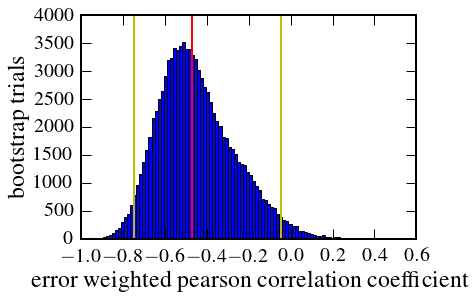

In [12]:
# run the correlation coefficent bootstrap
pearsons = []
   
for i in range(100000):
    newrv, newbs, newrverr, newbserr = bootstrap_arrays(finrv, finbs, finrverr, finbserr)
    pearsons.append(weighted_pearson(newrv,newbs,newrverr,newbserr))
    
# get the Bayesian estimates for the mean and std of the resulting pearson distribution
#mean, var, std = stats.bayes_mvs(np.array(pearsons),alpha=0.95)
#print('bootstrapped pearson coefficient mean = %s' % repr(mean))
#print('bootstrapped pearson coefficient std = %s' % repr(std))

# sort the pearsons, get the 2.5 and 97.5 percentiles, and check if 0 is within this range.
# if it is, then the correlation is not statistically significant at 95% confidence level
# if it isn't, then there does exist a statistically significant correlation
percentiles = np.percentile(pearsons,[2.5,97.5])
print 'bootstrapped Pearson coefficient 2.5 and 97.5 percentiles (95 percent confidence interval) = ', percentiles
print 'bootstrapped Pearson coefficient median = ', np.median(pearsons)
#print(pearsons[(pearsons > percentiles[0]) & (pearsons < percentiles[1])])
plt.hist(pearsons,bins=100)
plt.axvline(np.median(pearsons),linestyle='-',linewidth='2',color='r')
plt.axvline(percentiles[0],linestyle='-',linewidth='2',color='y')
plt.axvline(percentiles[1],linestyle='-',linewidth='2',color='y')
plt.xlabel('error weighted pearson correlation coefficient')
plt.ylabel('bootstrap trials')

In [13]:
# make sure to plot only the instruments that have finite BS and RV values
instrument

array(['Coralie', 'Coralie', 'Coralie', 'Coralie', 'Coralie', 'na', 'na',
       'na', 'na', 'na', 'na', 'FEROS', 'FEROS', 'FEROS', 'FEROS', 'FEROS',
       'FEROS', 'FEROS', 'na', 'FEROS', 'na', 'na', 'FEROS', 'na', 'na',
       'FEROS', 'na', 'FEROS'], 
      dtype='|S7')

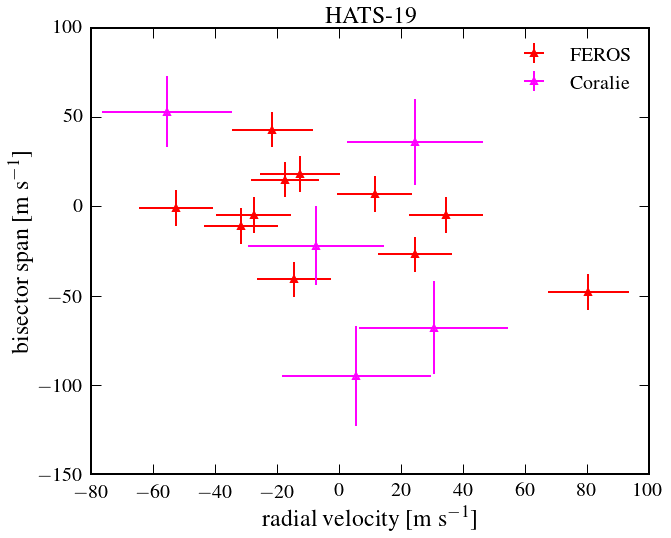

In [14]:
# fonts for the entire thing
matplotlib.rcParams['font.size'] = 20

# lines
matplotlib.rcParams['lines.linewidth'] = 2.0

# axes
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.labelsize'] = 'large'

# ticks
matplotlib.rcParams['xtick.major.size'] = 10.0
matplotlib.rcParams['xtick.minor.size'] = 5.0
matplotlib.rcParams['xtick.major.width'] = 1.0
matplotlib.rcParams['xtick.minor.width'] = 1.0
matplotlib.rcParams['xtick.major.pad'] = 8.0

matplotlib.rcParams['ytick.major.size'] = 10.0
matplotlib.rcParams['ytick.minor.size'] = 5.0
matplotlib.rcParams['ytick.major.width'] = 1.0
matplotlib.rcParams['ytick.minor.width'] = 1.0
matplotlib.rcParams['ytick.major.pad'] = 8.0

# legend
matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['legend.fontsize'] = 'medium'
matplotlib.rcParams['legend.frameon'] = False

plt.figure(figsize=(10,8))

plt.errorbar(rv[instrument == 'FEROS'],
             bs[instrument == 'FEROS'],
             xerr=bserr[instrument == 'FEROS'],
             yerr=rverr[instrument == 'FEROS'],
             linestyle='none',marker='^',mec='red',mfc='red',mew=2.0,ecolor='red',label='FEROS',capsize=0)
#plt.errorbar(rv[instrument == 'HARPS'],
#             bs[instrument == 'HARPS'],
#             xerr=bserr[instrument == 'HARPS'],
#             yerr=rverr[instrument == 'HARPS'],
#             linestyle='none',marker='o',mec='orange',mfc='orange',mew=2.0,ecolor='orange',label='HARPS',capsize=0)
#plt.errorbar(rv[instrument == 'PFS'],
#             bs[instrument == 'PFS'],
#             xerr=bserr[instrument == 'PFS'],
#             yerr=rverr[instrument == 'PFS'],
#             linestyle='none',marker='o',mec='blue',mfc='none',mew=2.0,ecolor='blue', label='PFS',capsize=0)
plt.errorbar(rv[instrument == 'Coralie'],
             bs[instrument == 'Coralie'],
             xerr=bserr[instrument == 'Coralie'],
             yerr=rverr[instrument == 'Coralie'],
             linestyle='none',marker='^',mec='#ff00ff',mfc='none',mew=2.0,ecolor='#ff00ff',label='Coralie',capsize=0)

plt.xlabel('radial velocity [$\mathrm{m\ s^{-1}}$]')
plt.ylabel('bisector span [$\mathrm{m\ s^{-1}}$]')
plt.title('HATS-19')
plt.legend(numpoints=1,frameon=False)
plt.savefig('hats-19-bs-rv-correl.pdf',bbox_inches='tight')

### HATS-20

In [15]:
# load the data file
table = !cat HATS-20b-RVs.txt

# get the columns
table = [x for x in table if '*' not in x]
table = [x.split() for x in table]
rv = np.array([(float(x[1]) if 'NULL' not in x else np.nan) for x in table])
rverr = np.array([(float(x[2]) if 'NULL' not in x else np.nan) for x in table])
bs = np.array([(float(x[3]) if 'NULL' not in x else np.nan) for x in table])
bserr = np.array([(float(x[4]) if 'NULL' not in x else np.nan) for x in table])
phase = np.array([(float(x[5]) if 'NULL' not in x else np.nan) for x in table])
instrument = np.array([(x[6] if 'NULL' not in x else 'na') for x in table])

# get the RVs and BS values
finind = np.isfinite(rv) & np.isfinite(bs)
finrv, finrverr = rv[finind], rverr[finind]
finbs, finbserr = bs[finind], bserr[finind]

bootstrapped Pearson coefficient 2.5 and 97.5 percentiles (95 percent confidence interval) =  [ 0.22428972  0.80619535]
bootstrapped Pearson coefficient median =  0.567201867364


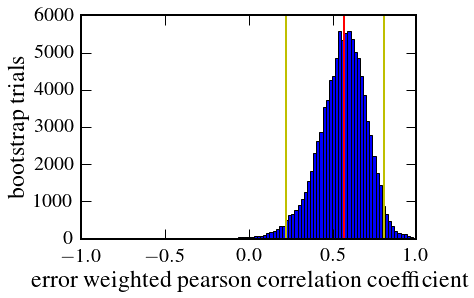

In [16]:
# run the correlation coefficent bootstrap
pearsons = []
   
for i in range(100000):
    newrv, newbs, newrverr, newbserr = bootstrap_arrays(finrv, finbs, finrverr, finbserr)
    pearsons.append(weighted_pearson(newrv,newbs,newrverr,newbserr))
    
# get the Bayesian estimates for the mean and std of the resulting pearson distribution
#mean, var, std = stats.bayes_mvs(np.array(pearsons),alpha=0.95)
#print('bootstrapped pearson coefficient mean = %s' % repr(mean))
#print('bootstrapped pearson coefficient std = %s' % repr(std))

# sort the pearsons, get the 2.5 and 97.5 percentiles, and check if 0 is within this range.
# if it is, then the correlation is not statistically significant at 95% confidence level
# if it isn't, then there does exist a statistically significant correlation
percentiles = np.percentile(pearsons,[2.5,97.5])
print 'bootstrapped Pearson coefficient 2.5 and 97.5 percentiles (95 percent confidence interval) = ', percentiles
print 'bootstrapped Pearson coefficient median = ', np.median(pearsons)
#print(pearsons[(pearsons > percentiles[0]) & (pearsons < percentiles[1])])
plt.hist(pearsons,bins=100)
plt.axvline(np.median(pearsons),linestyle='-',linewidth='2',color='r')
plt.axvline(percentiles[0],linestyle='-',linewidth='2',color='y')
plt.axvline(percentiles[1],linestyle='-',linewidth='2',color='y')
plt.xlabel('error weighted pearson correlation coefficient')
plt.ylabel('bootstrap trials')

In [17]:
# make sure to plot only the instruments that have finite BS and RV values
instrument

array(['FEROS', 'FEROS', 'FEROS', 'FEROS', 'FEROS', 'FEROS', 'FEROS',
       'FEROS', 'FEROS', 'FEROS'], 
      dtype='|S5')

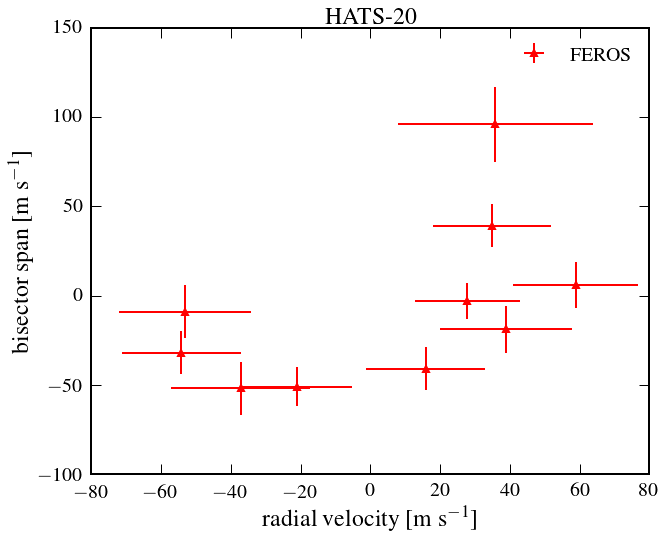

In [18]:
# fonts for the entire thing
matplotlib.rcParams['font.size'] = 20

# lines
matplotlib.rcParams['lines.linewidth'] = 2.0

# axes
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.labelsize'] = 'large'

# ticks
matplotlib.rcParams['xtick.major.size'] = 10.0
matplotlib.rcParams['xtick.minor.size'] = 5.0
matplotlib.rcParams['xtick.major.width'] = 1.0
matplotlib.rcParams['xtick.minor.width'] = 1.0
matplotlib.rcParams['xtick.major.pad'] = 8.0

matplotlib.rcParams['ytick.major.size'] = 10.0
matplotlib.rcParams['ytick.minor.size'] = 5.0
matplotlib.rcParams['ytick.major.width'] = 1.0
matplotlib.rcParams['ytick.minor.width'] = 1.0
matplotlib.rcParams['ytick.major.pad'] = 8.0

# legend
matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['legend.fontsize'] = 'medium'
matplotlib.rcParams['legend.frameon'] = False

plt.figure(figsize=(10,8))

plt.errorbar(rv[instrument == 'FEROS'],
             bs[instrument == 'FEROS'],
             xerr=bserr[instrument == 'FEROS'],
             yerr=rverr[instrument == 'FEROS'],
             linestyle='none',marker='^',mec='red',mfc='red',mew=2.0,ecolor='red',label='FEROS',capsize=0)
#plt.errorbar(rv[instrument == 'HARPS'],
#             bs[instrument == 'HARPS'],
#             xerr=bserr[instrument == 'HARPS'],
#             yerr=rverr[instrument == 'HARPS'],
#             linestyle='none',marker='o',mec='orange',mfc='orange',mew=2.0,ecolor='orange',label='HARPS',capsize=0)
#plt.errorbar(rv[instrument == 'PFS'],
#             bs[instrument == 'PFS'],
#             xerr=bserr[instrument == 'PFS'],
#             yerr=rverr[instrument == 'PFS'],
#             linestyle='none',marker='o',mec='blue',mfc='none',mew=2.0,ecolor='blue', label='PFS',capsize=0)
#plt.errorbar(rv[instrument == 'Coralie'],
#             bs[instrument == 'Coralie'],
#             xerr=bserr[instrument == 'Coralie'],
#             yerr=rverr[instrument == 'Coralie'],
#             linestyle='none',marker='^',mec='#ff00ff',mfc='none',mew=2.0,ecolor='#ff00ff',label='Coralie',capsize=0)

plt.xlabel('radial velocity [$\mathrm{m\ s^{-1}}$]')
plt.ylabel('bisector span [$\mathrm{m\ s^{-1}}$]')
plt.title('HATS-20')
plt.legend(numpoints=1,frameon=False)
plt.savefig('hats-20-bs-rv-correl.pdf',bbox_inches='tight')

### HATS-21

In [19]:
# load the data file
table = !cat HATS-21b-RVs.txt

# get the columns
table = [x for x in table if '*' not in x]
table = [x.split() for x in table]
rv = np.array([(float(x[1]) if 'NULL' not in x else np.nan) for x in table])
rverr = np.array([(float(x[2]) if 'NULL' not in x else np.nan) for x in table])
bs = np.array([(float(x[3]) if 'NULL' not in x else np.nan) for x in table])
bserr = np.array([(float(x[4]) if 'NULL' not in x else np.nan) for x in table])
phase = np.array([(float(x[5]) if 'NULL' not in x else np.nan) for x in table])
instrument = np.array([(x[6] if 'NULL' not in x else 'na') for x in table])

# get the RVs and BS values
finind = np.isfinite(rv) & np.isfinite(bs)
finrv, finrverr = rv[finind], rverr[finind]
finbs, finbserr = bs[finind], bserr[finind]

bootstrapped Pearson coefficient 2.5 and 97.5 percentiles (95 percent confidence interval) =  [-0.77133603  0.6961525 ]
bootstrapped Pearson coefficient median =  -0.203013152353


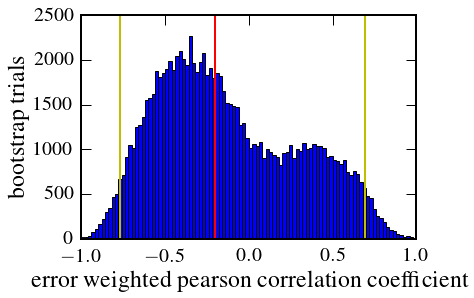

In [20]:
# run the correlation coefficent bootstrap
pearsons = []
   
for i in range(100000):
    newrv, newbs, newrverr, newbserr = bootstrap_arrays(finrv, finbs, finrverr, finbserr)
    pearsons.append(weighted_pearson(newrv,newbs,newrverr,newbserr))
    
# get the Bayesian estimates for the mean and std of the resulting pearson distribution
#mean, var, std = stats.bayes_mvs(np.array(pearsons),alpha=0.95)
#print('bootstrapped pearson coefficient mean = %s' % repr(mean))
#print('bootstrapped pearson coefficient std = %s' % repr(std))

# sort the pearsons, get the 2.5 and 97.5 percentiles, and check if 0 is within this range.
# if it is, then the correlation is not statistically significant at 95% confidence level
# if it isn't, then there does exist a statistically significant correlation
percentiles = np.percentile(pearsons,[2.5,97.5])
print 'bootstrapped Pearson coefficient 2.5 and 97.5 percentiles (95 percent confidence interval) = ', percentiles
print 'bootstrapped Pearson coefficient median = ', np.median(pearsons)
#print(pearsons[(pearsons > percentiles[0]) & (pearsons < percentiles[1])])
plt.hist(pearsons,bins=100)
plt.axvline(np.median(pearsons),linestyle='-',linewidth='2',color='r')
plt.axvline(percentiles[0],linestyle='-',linewidth='2',color='y')
plt.axvline(percentiles[1],linestyle='-',linewidth='2',color='y')
plt.xlabel('error weighted pearson correlation coefficient')
plt.ylabel('bootstrap trials')

In [21]:
# make sure to plot only the instruments that have finite BS and RV values
instrument

array(['HARPS', 'na', 'na', 'na', 'na', 'na', 'na', 'na', 'FEROS', 'FEROS',
       'FEROS', 'FEROS', 'FEROS', 'FEROS', 'FEROS', 'FEROS', 'HARPS'], 
      dtype='|S5')

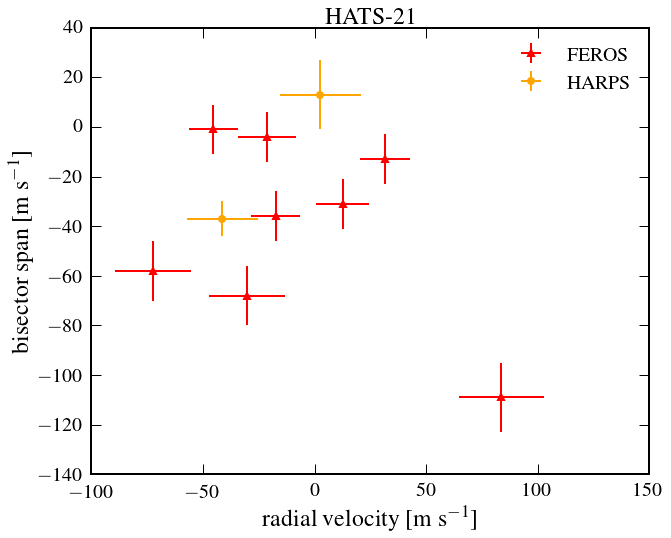

In [22]:
# fonts for the entire thing
matplotlib.rcParams['font.size'] = 20

# lines
matplotlib.rcParams['lines.linewidth'] = 2.0

# axes
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.labelsize'] = 'large'

# ticks
matplotlib.rcParams['xtick.major.size'] = 10.0
matplotlib.rcParams['xtick.minor.size'] = 5.0
matplotlib.rcParams['xtick.major.width'] = 1.0
matplotlib.rcParams['xtick.minor.width'] = 1.0
matplotlib.rcParams['xtick.major.pad'] = 8.0

matplotlib.rcParams['ytick.major.size'] = 10.0
matplotlib.rcParams['ytick.minor.size'] = 5.0
matplotlib.rcParams['ytick.major.width'] = 1.0
matplotlib.rcParams['ytick.minor.width'] = 1.0
matplotlib.rcParams['ytick.major.pad'] = 8.0

# legend
matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['legend.fontsize'] = 'medium'
matplotlib.rcParams['legend.frameon'] = False

plt.figure(figsize=(10,8))

plt.errorbar(rv[instrument == 'FEROS'],
             bs[instrument == 'FEROS'],
             xerr=bserr[instrument == 'FEROS'],
             yerr=rverr[instrument == 'FEROS'],
             linestyle='none',marker='^',mec='red',mfc='red',mew=2.0,ecolor='red',label='FEROS',capsize=0)
plt.errorbar(rv[instrument == 'HARPS'],
             bs[instrument == 'HARPS'],
             xerr=bserr[instrument == 'HARPS'],
             yerr=rverr[instrument == 'HARPS'],
             linestyle='none',marker='o',mec='orange',mfc='orange',mew=2.0,ecolor='orange',label='HARPS',capsize=0)
#plt.errorbar(rv[instrument == 'PFS'],
#             bs[instrument == 'PFS'],
#             xerr=bserr[instrument == 'PFS'],
#             yerr=rverr[instrument == 'PFS'],
#             linestyle='none',marker='o',mec='blue',mfc='none',mew=2.0,ecolor='blue', label='PFS',capsize=0)
#plt.errorbar(rv[instrument == 'Coralie'],
#             bs[instrument == 'Coralie'],
#             xerr=bserr[instrument == 'Coralie'],
#             yerr=rverr[instrument == 'Coralie'],
#             linestyle='none',marker='^',mec='#ff00ff',mfc='none',mew=2.0,ecolor='#ff00ff',label='Coralie',capsize=0)

plt.xlabel('radial velocity [$\mathrm{m\ s^{-1}}$]')
plt.ylabel('bisector span [$\mathrm{m\ s^{-1}}$]')
plt.title('HATS-21')
plt.legend(numpoints=1,frameon=False)
plt.savefig('hats-21-bs-rv-correl.pdf',bbox_inches='tight')

## Contrast curves from lucky imaging

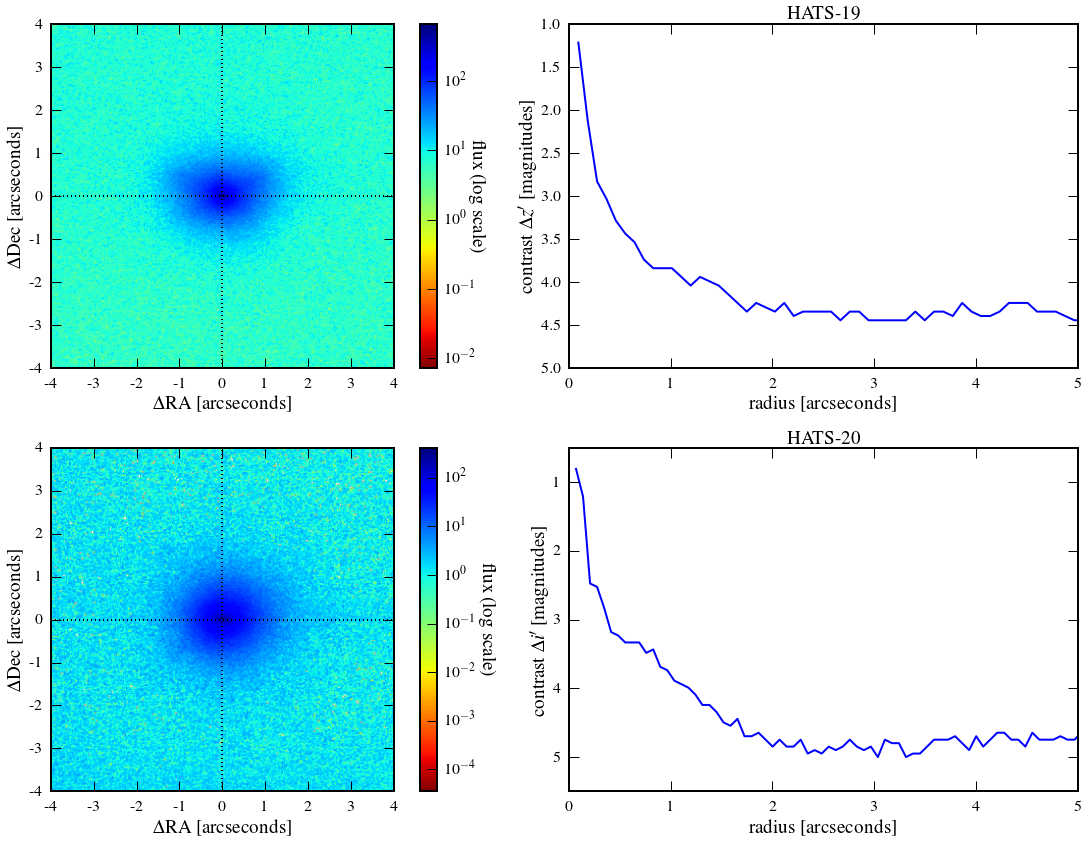

In [27]:
# fonts for the entire thing
matplotlib.rcParams['font.size'] = 16

# lines
matplotlib.rcParams['lines.linewidth'] = 2.0

# axes
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.labelsize'] = 'large'

# ticks
matplotlib.rcParams['xtick.major.size'] = 10.0
matplotlib.rcParams['xtick.minor.size'] = 5.0
matplotlib.rcParams['xtick.major.width'] = 1.0
matplotlib.rcParams['xtick.minor.width'] = 1.0
matplotlib.rcParams['xtick.major.pad'] = 8.0

matplotlib.rcParams['ytick.major.size'] = 10.0
matplotlib.rcParams['ytick.minor.size'] = 5.0
matplotlib.rcParams['ytick.major.width'] = 1.0
matplotlib.rcParams['ytick.minor.width'] = 1.0
matplotlib.rcParams['ytick.major.pad'] = 8.0

# legend
matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['legend.fontsize'] = 'medium'
matplotlib.rcParams['legend.frameon'] = False

plt.figure(figsize=(16,12))

target_x0, target_y0 = 521.2064048916659, 464.47876149973797

# HATS-19 AstraLux
plt.subplot(221)

frame = pyfits.open('HATS-19-astraluxsur-bestframe.fits')
framedata = frame[0].data

framemags = framedata

plt.imshow(framemags,norm=LogNorm())
plt.set_cmap('jet_r')

plt.axvline(521.2064048916659,color='k',linestyle=':')
plt.axhline(464.47876149973797,color='k',linestyle=':')

pixelscale = 23.7e-3 # per pixel

plt.xlim(target_x0 - 4/pixelscale,target_x0 + 4/pixelscale)
plt.ylim(target_y0 - 4/pixelscale, target_y0 + 4/pixelscale)
cbar = plt.colorbar()
cbar.ax.set_ylabel('flux (log scale)', rotation=270, labelpad=10)

xticksarcsecoffset = [-4,-3,-2,-1,0,1,2,3,4]
xtickspix = [(target_x0 + x/pixelscale) for x in xticksarcsecoffset]
yticksarcsecoffset = [-4,-3,-2,-1,0,1,2,3,4]
ytickspix = [(target_y0 + y/pixelscale) for y in yticksarcsecoffset]

xticks, xlabels = plt.xticks(xtickspix)
yticks, ylabels = plt.yticks(ytickspix)

plt.gca().set_xticklabels([-4,-3,-2,-1, 0, 1,2,3,4])
plt.gca().set_yticklabels([-4,-3,-2,-1, 0, 1,2,3,4])

plt.xlabel('$\Delta$RA [arcseconds]')
plt.ylabel('$\Delta$Dec [arcseconds]')


# HATS-19 contrast curve
hats19curve = !cat HATS-19-astraluxsur-contrastcurve.txt
hats19radius, hats19magcontrast, hats19error = ([float(x.split()[0]) for x in hats19curve[1:]], 
                              [float(x.split()[1]) for x in hats19curve[1:]],
                              [float(x.split()[2]) for x in hats19curve[1:]])
hats19radius, hats19magcontrast, hats19error = np.array(hats19radius), np.array(hats19magcontrast), np.array(hats19error)

plt.subplot(222)
plt.plot(hats19radius, hats19magcontrast)
plt.ylim(5.0,1.0)
plt.xlim(0,5.0)
plt.xlabel('radius [arcseconds]')
plt.ylabel('contrast $\Delta z^{\prime}$ [magnitudes]')
plt.title('HATS-19')



# HATS-20 AstraLux
hats20astralux = pyfits.open('HATS-20-astraluxsur-bestframe.fits')
hats20astraimg = hats20astralux[0].data
plt.subplot(223)

framemags = hats20astraimg
#framemags = framemags - np.nanmax(framemags)

plt.imshow(framemags,norm=LogNorm())
plt.set_cmap('jet_r')

hats20_x0 = 256.61493364830363
hats20_y0 = 242.188119473369

plt.axvline(hats20_x0,color='k',linestyle=':')
plt.axhline(hats20_y0,color='k',linestyle=':')

pixelscale = 23.7e-3 # per pixel

plt.xlim(hats20_x0 - 4/pixelscale,hats20_x0 + 4/pixelscale)
plt.ylim(hats20_y0 - 4/pixelscale,hats20_y0 + 4/pixelscale)
cbar = plt.colorbar()
cbar.ax.set_ylabel('flux (log scale)', rotation=270, labelpad=20)

xticksarcsecoffset = [-4,-3,-2,-1,0,1,2,3,4]
xtickspix = [(hats20_x0 + x/pixelscale) for x in xticksarcsecoffset]
yticksarcsecoffset = [-4,-3,-2,-1,0,1,2,3,4]
ytickspix = [(hats20_y0 + y/pixelscale) for y in yticksarcsecoffset]

xticks, xlabels = plt.xticks(xtickspix)
yticks, ylabels = plt.yticks(ytickspix)

plt.gca().set_xticklabels([-4,-3,-2,-1, 0, 1,2,3,4])
plt.gca().set_yticklabels([-4,-3,-2,-1, 0, 1,2,3,4])

plt.xlabel('$\Delta$RA [arcseconds]')
plt.ylabel('$\Delta$Dec [arcseconds]')

# HATS-20 contrast curve
hats20curve = !cat HATS-20-astraluxsur-contrastcurve.txt
hats20radius, hats20magcontrast, hats20error = ([float(x.split()[0]) for x in hats20curve[1:]], 
                              [float(x.split()[1]) for x in hats20curve[1:]],
                              [float(x.split()[2]) for x in hats20curve[1:]])
hats20radius, hats20magcontrast, hats20error = np.array(hats20radius), np.array(hats20magcontrast), np.array(hats20error)

plt.subplot(224)
plt.plot(hats20radius, hats20magcontrast)
plt.ylim(5.5,0.5)
plt.xlim(0,5.0)
plt.xlabel('radius [arcseconds]')
plt.ylabel('contrast $\Delta i^{\prime}$ [magnitudes]')
plt.title('HATS-20')

# finalize the figure
plt.tight_layout()
plt.savefig('lucky-imaging.pdf',bbox_inches='tight')

## Stellar variability

In [5]:
# get the light curves
hats19 = hatlc.read_csvlc('HATS-19b-hatlc.csv.gz')
hats20 = oldhatlc.read_hatlc('HATS-20b-old-hatlc.csv.gz')
hats21 = oldhatlc.read_hatlc('HATS-21b-old-hatlc.csv.gz')

2016-05-04T18:55:29.859062Z [INFO]: reading gzipped HATLC: HATS-19b-hatlc.csv.gz
2016-05-04T18:55:29.916215Z [WRN!]: could not understand header element "lcfiltersql =", skipped.
2016-05-04T18:55:29.916279Z [WRN!]: could not understand header element "lcnormcols =", skipped.


### HATS-19

2016-05-04T18:55:31.835120Z [INFO]: sigclip = 30.0: before = 20137 observations, after = 20135 observations


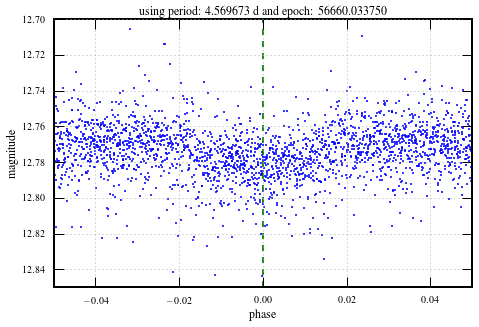

In [6]:
# plot the actual timeseries to see if we're phasing the target right
plotbase.plot_phased_mag_series(hats19['rjd'],hats19['aep_000'],
                                hats19_period,
                                epoch=hats19_epoch,
                                phasewrap=True,plotphaselim=[-0.05,0.05],phasebin=None,yrange=[12.7,12.85])

In [7]:
# mask the time series near primary and secondary eclipse
hats19_masked = varbase.mask_signal(hats19['rjd'],hats19['aep_000'],hats19['aie_000'],
                                    hats19_period,hats19_epoch,
                                    maskphaselength=0.1,sigclip=5.0)

2016-05-04T18:55:32.330977Z [INFO]: sigclip = 5.0: before = 20137 observations, after = 20032 observations


2016-05-04T18:55:32.339811Z [INFO]: sigclip = 30.0: before = 11699 observations, after = 11699 observations


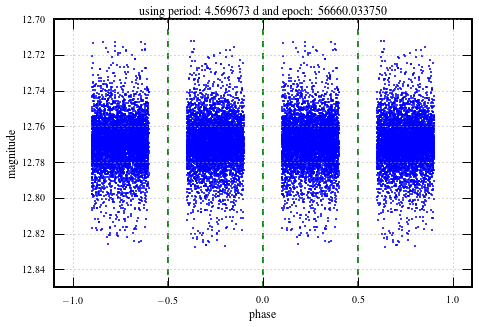

In [8]:
# plot the masked timeseries to make sure we got rid of the eclipses
plotbase.plot_phased_mag_series(hats19_masked['mtimes'],hats19_masked['mmags'],
                                hats19_period,
                                epoch=hats19_epoch,
                                phasewrap=True,plotphaselim=[-1.1,1.1],yrange=[12.7,12.85])

In [9]:
# run a period search on the masked time series from 0.1 to 100 days
x = periodbase.pgen_lsp(hats19_masked['mtimes'], hats19_masked['mmags'], hats19_masked['merrs'],0.1,100.0,sigclip=5.0)

2016-05-04T18:55:32.741737Z [INFO]: sigclip = 5.0: before = 11699 observations, after = 11689 observations


In [10]:
# look at the best periods
x['nbestperiods']

[0.16244050616461822,
 18.21493624772322,
 18.083182640144756,
 2.6116479498563749,
 18.315018315018403]

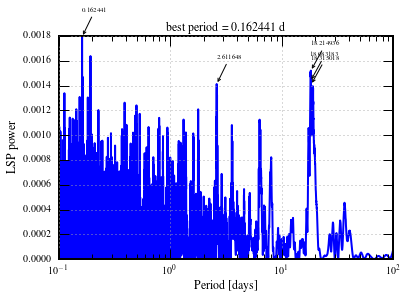

In [11]:
# plot the periodogram
plotbase.plot_periodbase_lsp(x)

2016-05-04T18:56:21.529348Z [INFO]: sigclip = 30.0: before = 11699 observations, after = 11699 observations


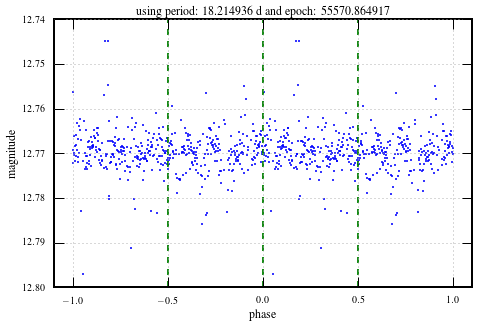

In [12]:
# plot the phased time series with the period that looks closest to the vrot period
# no rotation seen
plotbase.plot_phased_mag_series(hats19_masked['mtimes'],hats19_masked['mmags'],
                                x['nbestperiods'][1],epoch=None,phasewrap=True,
                                plotphaselim=[-1.1,1.1],phasebin=0.002)

### HATS-20

2016-05-04T18:56:23.123213Z [INFO]: sigclip = 30.0: before = 17973 observations, after = 16912 observations


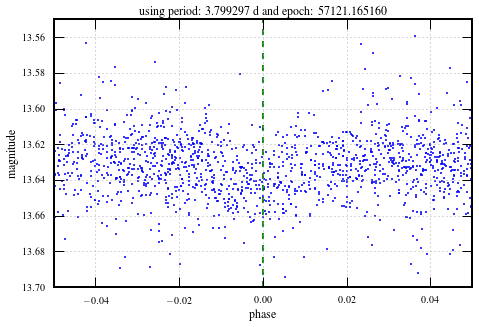

In [13]:
# plot the actual timeseries to see if we're phasing the target right
plotbase.plot_phased_mag_series(hats20['RJD'],hats20['EP1'],
                                hats20_period,
                                epoch=hats20_epoch,
                                phasewrap=True,plotphaselim=[-0.05,0.05],phasebin=None,
                                yrange=[13.55,13.7])

In [14]:
# mask the time series near primary and secondary eclipse
hats20_masked = varbase.mask_signal(hats20['RJD'],hats20['EP1'],hats20['IE1'],
                                    hats20_period,hats20_epoch,
                                    maskphaselength=0.1,sigclip=5.0)

2016-05-04T18:56:23.508457Z [INFO]: sigclip = 5.0: before = 17973 observations, after = 16235 observations


2016-05-04T18:56:23.519940Z [INFO]: sigclip = 30.0: before = 9891 observations, after = 9891 observations


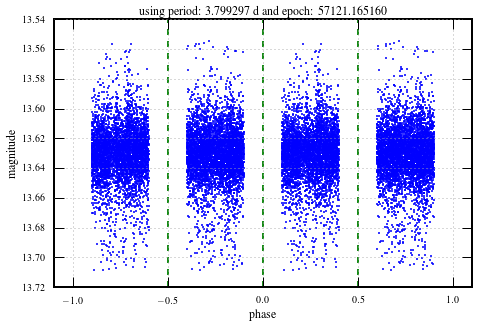

In [15]:
# plot the masked timeseries to make sure we got rid of the eclipses
plotbase.plot_phased_mag_series(hats20_masked['mtimes'],hats20_masked['mmags'],
                                hats20_period,
                                epoch=hats20_epoch,
                                phasewrap=True,plotphaselim=[-1.1,1.1])

In [16]:
# run a period search on the masked time series from 0.1 to 100 days
x = periodbase.pgen_lsp(hats20_masked['mtimes'], hats20_masked['mmags'], hats20_masked['merrs'],0.1,100.0,sigclip=5.0)

2016-05-04T18:56:23.954183Z [INFO]: sigclip = 5.0: before = 9891 observations, after = 9861 observations


In [17]:
# look at the best periods
x['nbestperiods']

[0.49813200498132304,
 0.99472794190789426,
 0.19939781858786587,
 20.92050209205031,
 21.052631578947469]

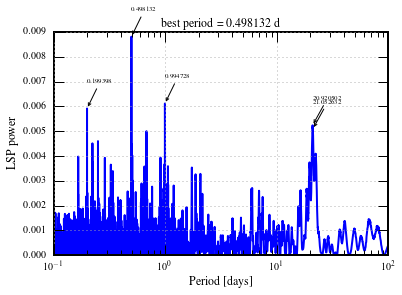

In [18]:
# plot the periodogram
plotbase.plot_periodbase_lsp(x)

2016-05-04T18:57:04.528366Z [INFO]: sigclip = 3.0: before = 9891 observations, after = 9535 observations


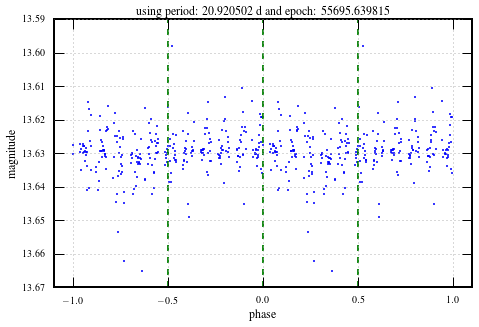

In [19]:
# plot the phased time series with the period
# no significant rotation?
plotbase.plot_phased_mag_series(hats20_masked['mtimes'],hats20_masked['mmags'],
                                x['nbestperiods'][3],epoch=None,phasebin=0.002,
                                phasewrap=True,plotphaselim=[-1.1,1.1],sigclip=3.0)

### HATS-21

2016-05-04T18:57:05.731340Z [INFO]: sigclip = 30.0: before = 13759 observations, after = 13235 observations


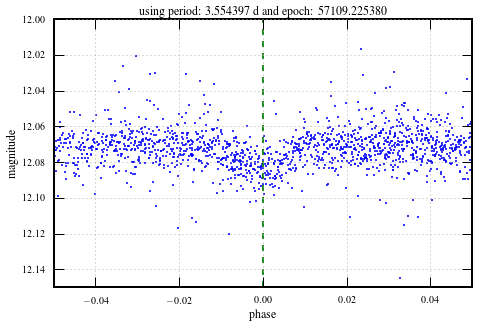

In [20]:
# plot the actual timeseries to see if we're phasing the target right
plotbase.plot_phased_mag_series(hats21['RJD'],hats21['EP1'],
                                hats21_period,
                                epoch=hats21_epoch,
                                phasewrap=True,plotphaselim=[-0.05,0.05],phasebin=None,
                                yrange=[12.00,12.15])

In [21]:
# mask the time series near primary and secondary eclipse
hats21_masked = varbase.mask_signal(hats21['RJD'],hats21['EP1'],hats21['IE1'],
                                    hats21_period,hats21_epoch,
                                    maskphaselength=0.1,sigclip=5.0)

2016-05-04T18:57:06.069450Z [INFO]: sigclip = 5.0: before = 13759 observations, after = 13154 observations


2016-05-04T18:57:06.078513Z [INFO]: sigclip = 30.0: before = 7986 observations, after = 7986 observations


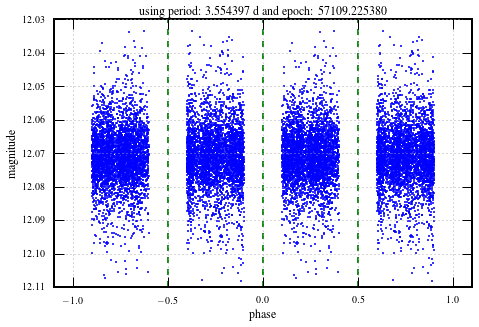

In [22]:
# plot the masked timeseries to make sure we got rid of the eclipses
plotbase.plot_phased_mag_series(hats21_masked['mtimes'],hats21_masked['mmags'],
                                hats21_period,
                                epoch=hats21_epoch,
                                phasewrap=True,plotphaselim=[-1.1,1.1])

In [23]:
# run a period search on the masked time series from 0.1 to 100 days
x = periodbase.pgen_lsp(hats21_masked['mtimes'], hats21_masked['mmags'], hats21_masked['merrs'],0.1,100.0,sigclip=5.0)

2016-05-04T18:57:06.494905Z [INFO]: sigclip = 5.0: before = 7986 observations, after = 7985 observations


In [24]:
# look at the best periods
x['nbestperiods']

[1.2577034335303812,
 4.2992261392949516,
 0.41002091106646688,
 1.0081661457808306,
 0.14998125234345799]

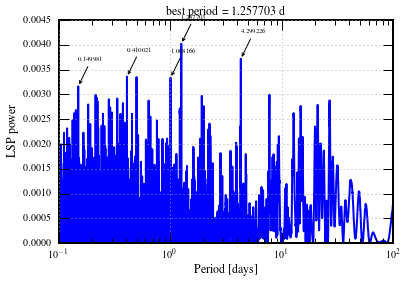

In [25]:
# plot the periodogram
plotbase.plot_periodbase_lsp(x)

2016-05-04T18:57:40.522592Z [INFO]: sigclip = 30.0: before = 7986 observations, after = 7986 observations
2016-05-04T18:57:40.523310Z [INFO]: sigclip = 30.0: before = 7986 observations, after = 7986 observations
2016-05-04T18:57:40.527320Z [INFO]: spline fit done. nknots = 79,  chisq = 24432.17385, reduced chisq = 3.09033


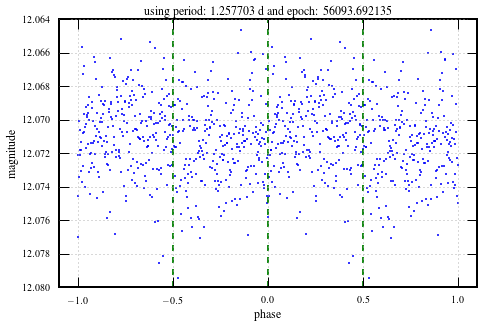

In [26]:
# plot the phased time series with the period
# no significant rotation?
plotbase.plot_phased_mag_series(hats21_masked['mtimes'],hats21_masked['mmags'],
                                x['nbestperiods'][0],epoch='min',phasewrap=True,
                                plotphaselim=[-1.1,1.1], phasebin=0.002)

## Mass-radius plot

In [2]:
# get the isochrones
coremass0age45 = fortney2k7.massradius(4.5,0.045,0)
coremass10age45 = fortney2k7.massradius(4.5,0.045,10)
coremass25age45 = fortney2k7.massradius(4.5,0.045,25)
coremass50age45 = fortney2k7.massradius(4.5,0.045,50)
coremass100age45 = fortney2k7.massradius(4.5,0.045,100)

coremass0age1 = fortney2k7.massradius(1.0,0.045,0)
coremass10age1 = fortney2k7.massradius(1.0,0.045,10)
coremass25age1 = fortney2k7.massradius(1.0,0.045,25)
coremass50age1 = fortney2k7.massradius(1.0,0.045,50)
coremass100age1 = fortney2k7.massradius(1.0,0.045,100)

getting  4.5yr M-R for planet dist 0.045 AU, core mass 0 Mearth...
getting  4.5yr M-R for planet dist 0.045 AU, core mass 10 Mearth...
getting  4.5yr M-R for planet dist 0.045 AU, core mass 25 Mearth...
getting  4.5yr M-R for planet dist 0.045 AU, core mass 50 Mearth...
getting  4.5yr M-R for planet dist 0.045 AU, core mass 100 Mearth...
getting  1yr M-R for planet dist 0.045 AU, core mass 0 Mearth...
getting  1yr M-R for planet dist 0.045 AU, core mass 10 Mearth...
getting  1yr M-R for planet dist 0.045 AU, core mass 25 Mearth...
getting  1yr M-R for planet dist 0.045 AU, core mass 50 Mearth...
getting  1yr M-R for planet dist 0.045 AU, core mass 100 Mearth...


In [3]:
# interpolate the M-R function for a smoother line

# core mass = 0, age 4.5 Gyr
interpolated_mr0 = interpolate.interp1d(coremass0age45['mass'],coremass0age45['radius'])
model_masses0 = np.linspace(0.1,5.0,num=1000)
model_radii0 = interpolated_mr0(model_masses0)

# core mass = 10, age 4.5 Gyr
interpolated_mr1 = interpolate.interp1d(coremass10age45['mass'],coremass10age45['radius'])
model_masses1 = np.linspace(0.1,5.0,num=1000)
model_radii1 = interpolated_mr1(model_masses1)

# core mass = 25, age 4.5 Gyr
interpolated_mr2 = interpolate.interp1d(coremass25age45['mass'],coremass25age45['radius'])
model_masses2 = np.linspace(0.1,5.0,num=1000)
model_radii2 = interpolated_mr2(model_masses2)

# core mass = 50, age 4.5 Gyr
interpolated_mr3 = interpolate.interp1d(coremass50age45['mass'],coremass50age45['radius'])
model_masses3 = np.linspace(0.1,5.0,num=1000)
model_radii3 = interpolated_mr3(model_masses3)

# core mass = 100, age 4.5 Gyr
interpolated_mr4 = interpolate.interp1d(coremass100age45['mass'],coremass100age45['radius'])
model_masses4 = np.linspace(0.1,5.0,num=1000)
model_radii4 = interpolated_mr4(model_masses4)


# core mass = 0, age 1.0 Gyr
interpolated_mr5 = interpolate.interp1d(coremass0age1['mass'],coremass0age1['radius'])
model_masses5 = np.linspace(0.1,5.0,num=1000)
model_radii5 = interpolated_mr5(model_masses5)

# core mass = 10, age 1.0 Gyr
interpolated_mr6 = interpolate.interp1d(coremass10age1['mass'],coremass10age1['radius'])
model_masses6 = np.linspace(0.1,5.0,num=1000)
model_radii6 = interpolated_mr6(model_masses6)

# core mass = 25, age 1.0 Gyr
interpolated_mr7 = interpolate.interp1d(coremass25age1['mass'],coremass25age1['radius'])
model_masses7 = np.linspace(0.1,5.0,num=1000)
model_radii7 = interpolated_mr7(model_masses7)

# core mass = 50, age 1.0 Gyr
interpolated_mr8 = interpolate.interp1d(coremass50age1['mass'],coremass50age1['radius'])
model_masses8 = np.linspace(0.1,5.0,num=1000)
model_radii8 = interpolated_mr8(model_masses8)

# core mass = 100, age 1.0 Gyr
interpolated_mr9 = interpolate.interp1d(coremass100age1['mass'],coremass100age1['radius'])
model_masses9 = np.linspace(0.1,5.0,num=1000)
model_radii9 = interpolated_mr9(model_masses9)

In [4]:
# load the planet data
planetmr = np.genfromtxt('planet-mass-radius-with-errors.csv',
                         usecols=(0,
                                  1,2,3,
                                  5,6,7,
                                  9,10,11,
                                  13,14,15,
                                  17,18,19,
                                  25,26,27,
                                  29,30,31,
                                  33,34,35,
                                  37,38,39,
                                  41,42,43),
                         names=['planet',
                                'Mp','Mpu','Mpd',
                                'Rp','Rpu','Rpd',
                                'a','au','ad',
                                'P','Pu','Pd',
                                'e','eu','ed',
                                'Ms','Msu','Msd',
                                'Rs','Rsu','Rsd',
                                'logg','loggu','loggd',
                                'Teff','Teffu','Teffd',
                                'FEH','FEHu','FEHd'],
                         dtype=('S20,'
                                'f8,f8,f8,'
                                'f8,f8,f8,'
                                'f8,f8,f8,'
                                'f8,f8,f8,'
                                'f8,f8,f8,'
                                'f8,f8,f8,'
                                'f8,f8,f8,'
                                'f8,f8,f8,'
                                'f8,f8,f8,'
                                'f8,f8,f8'),
                         delimiter=',')

finite M+R planets with mass > 0.1 Mj = 252


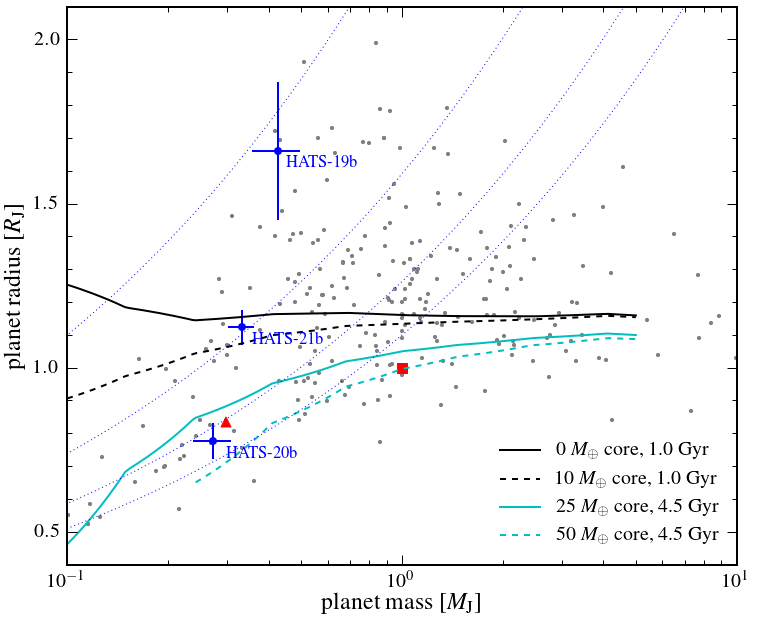

In [9]:
# make the M-R plot

# get the isodensity lines
isorho_masses = np.linspace(0.05,10.0,num=1000) # in jupiter masses

# set up fonts and stuff
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.labelsize'] = 'large'
matplotlib.rcParams['xtick.major.size'] = 10.0
matplotlib.rcParams['xtick.minor.size'] = 5.0
matplotlib.rcParams['xtick.major.width'] = 1.0
matplotlib.rcParams['xtick.minor.width'] = 1.0
matplotlib.rcParams['xtick.major.pad'] = 8.0
matplotlib.rcParams['ytick.major.size'] = 10.0
matplotlib.rcParams['ytick.minor.size'] = 5.0
matplotlib.rcParams['ytick.major.width'] = 1.0
matplotlib.rcParams['ytick.minor.width'] = 1.0
matplotlib.rcParams['ytick.major.pad'] = 8.0
matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['legend.fontsize'] = 'medium'
matplotlib.rcParams['legend.frameon'] = False

plt.figure(figsize=(12,10))

finind = np.isfinite(planetmr['Mp']) & np.isfinite(planetmr['Rp'])
planetmasses = planetmr['Mp'][finind]
planetradii = planetmr['Rp'][finind]

# plot all known transiting exoplanets with mass > 0.1 Mjup
plt.scatter(planetmasses[planetmasses > 0.1],
            planetradii[planetmasses > 0.1],
            s=40,color='grey',marker='.')

print('finite M+R planets with mass > 0.1 Mj = %s' % len(planetmasses[planetmasses > 0.1]))

# fix plot scale and limits to log and 0.1,10.0
plt.xscale('log')
plt.xlim(0.1,10)
plt.ylim(0.4,2.1)

# plot HATS-19, 20, 21
plt.errorbar(np.array([hats19_mass]),np.array([hats19_radius]),
             xerr=np.array([hats19_masserrs]),yerr=np.array([hats19_radiuserrs]), 
             color='blue',ecolor='blue',marker='o',mec='blue',mew=0.0,ms=8.0,capsize=0)

plt.errorbar(np.array([hats20_mass]),np.array([hats20_radius]),
             xerr=np.array([hats20_masserrs]),yerr=np.array([hats20_radiuserrs]), 
             color='blue',ecolor='blue',marker='o',mec='blue',mew=0.0,ms=8.0,capsize=0)

plt.errorbar(np.array([hats21_mass]),np.array([hats21_radius]),
             xerr=np.array([hats21_masserrs]),yerr=np.array([hats21_radiuserrs]), 
             color='blue',ecolor='blue',marker='o',mec='blue',mew=0.0,ms=8.0,capsize=0)

# plot the solar system planets Jupiter and Saturn
plt.scatter([1.0],[1.0],s=100,color='r',marker='s')
plt.scatter([0.299],[0.833],s=100,color='r',marker='^')

# plot the M-R relations from Fortney 2007
plt.plot(model_masses5,model_radii5,linestyle='-',label='$0\ M_{\oplus}$\ core, 1.0 Gyr',color='k',linewidth=2.0)
plt.plot(model_masses6,model_radii6,linestyle='--',label='$10\ M_{\oplus}$\ core, 1.0 Gyr',color='k',linewidth=2.0)

plt.plot(model_masses2,model_radii2,linestyle='-',label='$25\ M_{\oplus}$\ core, 4.5 Gyr',color='c',linewidth=2.0)
plt.plot(model_masses3,model_radii3,linestyle='--',label='$50\ M_{\oplus}$\ core, 4.5 Gyr',color='c',linewidth=2.0)

# plot the isodensity lines
plt.plot(isorho_masses,isorho_radius(0.1, isorho_masses),linestyle=':',color='blue',linewidth=1.0)
plt.plot(isorho_masses,isorho_radius(0.33, isorho_masses),linestyle=':',color='blue',linewidth=1.0)
plt.plot(isorho_masses,isorho_radius(0.66, isorho_masses),linestyle=':',color='blue',linewidth=1.0)
plt.plot(isorho_masses,isorho_radius(1.0, isorho_masses),linestyle=':',color='blue',linewidth=1.0)

# annotate the plot to point out the planets and isochrones
plt.text(hats19_mass+0.025,hats19_radius-0.05,'HATS-19b',color='blue',fontdict={'size':'small'})
plt.text(hats20_mass+0.025,hats20_radius-0.05,'HATS-20b',color='blue',fontdict={'size':'small'})
plt.text(hats21_mass+0.025,hats21_radius-0.05,'HATS-21b',color='blue',fontdict={'size':'small'})

plt.legend(loc='lower right')

# major and minor ticks on x/y axis
plt.gca().set_yticks([0.5,1.0,1.5,2.0])
plt.gca().set_yticks([0.6,0.7,0.8,0.9,1.1,1.2,1.3,1.4,1.6,1.7,1.8,1.9],minor=True)

# plot axis labels
plt.xlabel('planet mass [$M_{\mathrm{J}}$]')
plt.ylabel('planet radius [$R_{\mathrm{J}}$]')

plt.savefig('mass-radius.pdf',bbox_inches='tight')

## Radius-Teq-FEH correlations

In [11]:
# find the planets with finite values of measurements
finind = (np.isfinite(planetmr['Mp']) & np.isfinite(planetmr['Rp']) & 
          np.isfinite(planetmr['Teff']) & np.isfinite(planetmr['Rs']) & 
          np.isfinite(planetmr['a']) & np.isfinite(planetmr['e']) & np.isfinite(planetmr['FEH']))

planetmasses = planetmr['Mp'][finind]
planetmasserrs = (np.abs(planetmr[finind]['Mpu']) + np.abs(planetmr[finind]['Mpd']))/2.0

planetradii = planetmr['Rp'][finind]
planetradiierrs = (np.abs(planetmr[finind]['Rpu']) + np.abs(planetmr[finind]['Rpd']))/2.0

startemps = planetmr['Teff'][finind]
startemperrs = (np.abs(planetmr[finind]['Teffu']) + np.abs(planetmr[finind]['Teffd']))/2.0

starmasses = planetmr['Ms'][finind]
starmasserrs = (np.abs(planetmr[finind]['Msu']) + np.abs(planetmr[finind]['Msd']))/2.0

starradii = planetmr['Rs'][finind]
starradiierrs = (np.abs(planetmr[finind]['Rsu']) + np.abs(planetmr[finind]['Rsd']))/2.0

planetsemimajaxes = planetmr['a'][finind]
planetsemimajaxeserrs = (np.abs(planetmr[finind]['au']) + np.abs(planetmr[finind]['ad']))/2.0

planetperiods = planetmr['P'][finind]
planetperioderrs = (np.abs(planetmr[finind]['Pu']) + np.abs(planetmr[finind]['Pd']))/2.0

planeteccs = planetmr['e'][finind]
planeteccerrs = (np.abs(planetmr[finind]['eu']) + np.abs(planetmr[finind]['ed']))/2.0

starfehs = planetmr['FEH'][finind]
starfeherrs = (np.abs(planetmr[finind]['FEHu']) + np.abs(planetmr[finind]['FEHd']))/2.0

# calculate the equivalent temperatures assuming A = 0 (albedo), and F = 1
planet_teq = startemps*np.sqrt(starradii/(2.0*planetsemimajaxes*au_sunrad))

# calculate the tidal heating rates
planet_tidal = planet_tidal_heating_rate(starmasses, planetradii, planetsemimajaxes, planeteccs)

In [12]:
# get the various sub-samples from this sample
saturns = (planetmasses > 0.1) & (planetmasses < 0.5) & (planetperiods < 10.0)
jupiters = (planetmasses > 0.5) & (planetmasses < 2.0) & (planetperiods < 10.0)
himass = (planetmasses > 2.0) & (planetperiods < 10.0)
allp = (planetmasses > 0.1) & (planetperiods < 10.0)

## SATURNS + our 3 planets
satmass = np.concatenate((planetmasses[saturns], np.array([hats19_mass, hats20_mass, hats21_mass])))
satfeh = np.concatenate((starfehs[saturns], np.array([hats19_feh, hats20_feh, hats21_feh])))
sata = np.concatenate((planetsemimajaxes[saturns], np.array([hats19_a, hats20_a, hats21_a])))
satteq = np.concatenate((planet_teq[saturns], np.array([hats19_teq,hats20_teq,hats21_teq])))
satstarmass = np.concatenate((starmasses[saturns], np.array([hats19_starmass, hats20_starmass, hats21_starmass])))
satstarradii = np.concatenate((starradii[saturns], np.array([hats19_starrad, hats20_starrad, hats21_starrad])))
satecc = np.concatenate((planeteccs[saturns], np.array([hats19_ecc,hats20_ecc,hats21_ecc])))
sattidalh = np.concatenate((planet_tidal[saturns]/1.0e20, np.array([59.36898344899341,0.0,0.0])))
satradii = np.concatenate((planetradii[saturns], np.array([hats19_radius,hats20_radius,hats21_radius])))
satradiierrs = np.concatenate((planetradiierrs[saturns], 
                               np.ravel([(np.sum(np.abs(hats19_radiuserrs))/2.0,
                                          np.sum(np.abs(hats20_radiuserrs))/2.0,
                                          np.sum(np.abs(hats21_radiuserrs))/2.0)])))

## JUPITERS
jupmass = planetmasses[jupiters]
jupfeh = starfehs[jupiters]
jupa = planetsemimajaxes[jupiters]
jupteq = planet_teq[jupiters]
jupstarmass = starmasses[jupiters]
jupstarradii = starradii[jupiters]
jupecc = planeteccs[jupiters]
juptidalh = planet_tidal[jupiters]/1.0e20
jupradii = planetradii[jupiters]
jupradiierrs = planetradiierrs[jupiters]

# HIGH MASS
hipmass = planetmasses[himass]
hipfeh = starfehs[himass]
hipa = planetsemimajaxes[himass]
hipteq = planet_teq[himass]
hipstarmass = starmasses[himass]
hipstarradii = starradii[himass]
hipecc = planeteccs[himass]
hiptidalh = planet_tidal[himass]/1.0e20
hipradii = planetradii[himass]
hipradiierrs = planetradiierrs[himass]

# ALL PLANETS WITH M > 0.1 Mj and P < 10.0 days
allpmass = planetmasses[allp]
allpfeh = starfehs[allp]
allpa = planetsemimajaxes[allp]
allpteq = planet_teq[allp]
allpstarmass = starmasses[allp]
allpstarradii = starradii[allp]
allpecc = planeteccs[allp]
allptidalh = planet_tidal[allp]/1.0e20
allpradii = planetradii[allp]
allpradiierrs = planetradiierrs[allp]

In [33]:
##################
## CORRELATIONS ##
##################

teq_pearsons = []
feh_pearsons = []

# bootstrap the teq-Rp relation
# there's obviously a correlation, just need to prove it's statistically significant
for i in range(100000):
    
    newteq, newprad, newteqerr, newpraderr = bootstrap_arrays(allpteq, allpradii, None, None)
    teq_pearsons.append(weighted_pearson(newteq,newprad,newteqerr,newpraderr))
    
# sort the pearsons, get the 2.5 and 97.5 percentiles, and check if 0 is within this range.
# if it is, then the correlation is not statistically significant at 95% confidence level
# if it isn't, then there does exist a statistically significant correlation
teq_percentiles = np.percentile(teq_pearsons,[2.5,16.0,84.0,97.5])
print('Teq-Rp bootstrapped Pearson 95 percent confidence interval = %s' %
      [teq_percentiles[0], teq_percentiles[-1]])
print('Teq-Rp bootstrapped Pearson 68 percent confidence interval = %s' %
      [teq_percentiles[1], teq_percentiles[2]])
print 'Teq-Rp bootstrapped Pearson coefficient median = ', np.median(teq_pearsons)

# bootstrap the feh-prad correl
for i in range(100000):
    newfeh, newprad, newteqerr, newpraderr = bootstrap_arrays(allpfeh, allpradii, None, None)
    feh_pearsons.append(weighted_pearson(newfeh,newprad,newteqerr,newpraderr))

feh_percentiles = np.percentile(feh_pearsons,[2.5,16.0,84.0,97.5])
print('FEH-Rp bootstrapped Pearson 95 percent confidence interval = %s' %
      [feh_percentiles[0], feh_percentiles[-1]])
print('FEH-Rp bootstrapped Pearson 68 percent confidence interval = %s' %
      [feh_percentiles[1], feh_percentiles[2]])
print 'FEH-Rp bootstrapped Pearson coefficient median = ', np.median(feh_pearsons)

Teq-Rp bootstrapped Pearson 95 percent confidence interval = [0.51835462911405006, 0.70157271565154578]
Teq-Rp bootstrapped Pearson 68 percent confidence interval = [0.56849495964744223, 0.66108111456118157]
Teq-Rp bootstrapped Pearson coefficient median =  0.616548269561
FEH-Rp bootstrapped Pearson 95 percent confidence interval = [-0.28691667957702427, -0.015396336033249677]
FEH-Rp bootstrapped Pearson 68 percent confidence interval = [-0.22330438864418622, -0.085077252068891232]
FEH-Rp bootstrapped Pearson coefficient median =  -0.154843286793


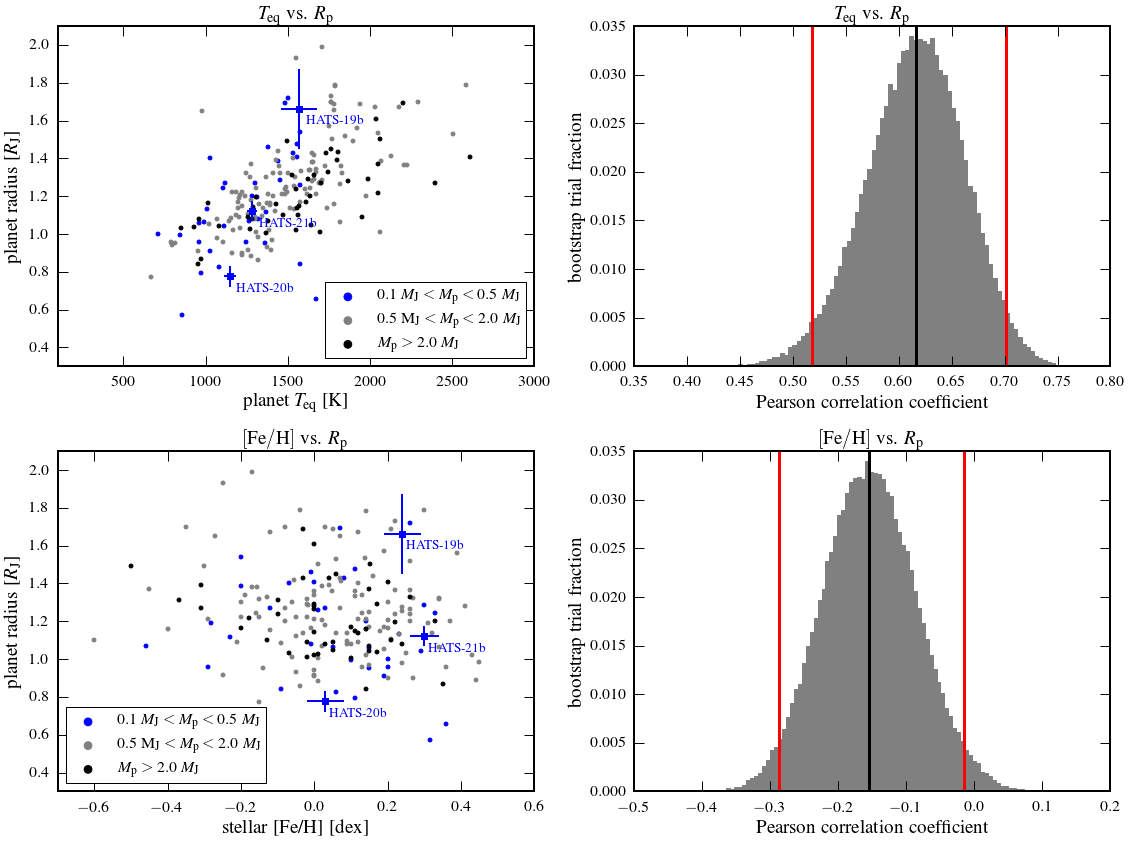

In [34]:
# NOW MAKE THE PLOTS

# fonts for the entire thing
matplotlib.rcParams['font.size'] = 16

# lines
matplotlib.rcParams['lines.linewidth'] = 2.0

# axes
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.labelsize'] = 'large'

# ticks
matplotlib.rcParams['xtick.major.size'] = 10.0
matplotlib.rcParams['xtick.minor.size'] = 5.0
matplotlib.rcParams['xtick.major.width'] = 1.0
matplotlib.rcParams['xtick.minor.width'] = 1.0
matplotlib.rcParams['xtick.major.pad'] = 8.0

matplotlib.rcParams['ytick.major.size'] = 10.0
matplotlib.rcParams['ytick.minor.size'] = 5.0
matplotlib.rcParams['ytick.major.width'] = 1.0
matplotlib.rcParams['ytick.minor.width'] = 1.0
matplotlib.rcParams['ytick.major.pad'] = 8.0

# legend
matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['legend.fontsize'] = 'medium'
matplotlib.rcParams['legend.frameon'] = False
matplotlib.rcParams['legend.markerscale'] = 2.0

###########
## PLOTS ##
###########
fig = plt.figure(figsize=(16,12))

###############
## Teq vs Rp ##
###############
plt.subplot(221)

# plot all known transiting exoplanets with 0.1 < Mp < 0.5 Mjup and periods < 10.0 days
plt.scatter(satteq,
            satradii,
            s=60,color='blue',marker='.',
            label='$0.1\ M_{\mathrm{J}} < M_{\mathrm{p}} < 0.5\ M_{\mathrm{J}}$')

# plot all known transiting exoplanets with 0.5 < Mp < 2.0 Mjup and periods < 10.0 days
plt.scatter(jupteq,
            jupradii,
            s=60,color='grey',marker='.',
            label='0.5\ M_{\mathrm{J}} < M_{\mathrm{p}} < 2.0\ M_{\mathrm{J}}$')
plt.legend(loc='lower right',scatterpoints=1,frameon=True)

# plot all known transiting exoplanets with 0.5 < Mp < 2.0 Mjup and periods < 10.0 days
plt.scatter(hipteq,
            hipradii,
            s=60,color='black',marker='.',
            label='$M_{\mathrm{p}} > 2.0\ M_{\mathrm{J}}$')
plt.legend(loc='lower right',scatterpoints=1,frameon=True)

# plot HATS-19, 20, 21
plt.errorbar(np.array([hats19_teq]),np.array([hats19_radius]),
             xerr=np.array([hats19_teq_err]),yerr=np.array([hats19_radiuserrs]), 
             color='b',ecolor='b',marker='s',mec='b',mew=0.0,ms=7.0,capsize=0)

plt.errorbar(np.array([hats20_teq]),np.array([hats20_radius]),
             xerr=np.array([hats20_teq_err]),yerr=np.array([hats20_radiuserrs]), 
             color='b',ecolor='b',marker='s',mec='b',mew=0.0,ms=7.0,capsize=0)

plt.errorbar(np.array([hats21_teq]),np.array([hats21_radius]),
             xerr=np.array([hats21_teq_err]),yerr=np.array([hats21_radiuserrs]), 
             color='b',ecolor='b',marker='s',mec='b',mew=0.0,ms=7.0,capsize=0)

# annotate the plot to point out the planets and isochrones
plt.text(hats19_teq+40,hats19_radius-0.08,'HATS-19b',color='b',fontdict={'size':'small'})
plt.text(hats20_teq+40,hats20_radius-0.08,'HATS-20b',color='b',fontdict={'size':'small'})
plt.text(hats21_teq+40,hats21_radius-0.08,'HATS-21b',color='b',fontdict={'size':'small'})

plt.xlim(100,3000)
plt.ylim(0.3,2.1)
plt.gca().set_yticks([0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0])

plt.xlabel('planet $T_{\mathrm{eq}}$ [K]')
plt.ylabel('planet radius [$R_{\mathrm{J}}$]')
plt.title('$T_{\mathrm{eq}}$ vs. $R_{\mathrm{p}}$')

########################################
## the correlation between Teq and Rp ##
########################################
plt.subplot(222)
plt.hist(teq_pearsons,bins=100,color='grey',linewidth=1,
         weights=np.ones_like(teq_pearsons)/len(teq_pearsons),edgecolor='grey')
plt.axvline(np.median(teq_pearsons),linestyle='-',linewidth='3',color='k')
plt.axvline(teq_percentiles[0],linestyle='-',linewidth='3',color='r')
plt.axvline(teq_percentiles[3],linestyle='-',linewidth='3',color='r')
plt.xlabel('Pearson correlation coefficient')
plt.ylabel('bootstrap trial fraction')
plt.title('$T_{\mathrm{eq}}$ vs. $R_{\mathrm{p}}$')

###############
## FEH vs Rp ##
###############
plt.subplot(223)

# plot all known transiting exoplanets with 0.1 < Mp < 0.5 Mjup and periods < 10.0 days
plt.scatter(satfeh,
            satradii,
            s=60,color='blue',marker='.',
            label='$0.1\ M_{\mathrm{J}} < M_{\mathrm{p}} < 0.5\ M_{\mathrm{J}}$')

# plot all known transiting exoplanets with 0.5 < Mp < 2.0 Mjup and periods < 10.0 days
plt.scatter(jupfeh,
            jupradii,
            s=60,color='grey',marker='.',
            label='0.5\ M_{\mathrm{J}} < M_{\mathrm{p}} < 2.0\ M_{\mathrm{J}}$')
plt.legend(loc='lower right',scatterpoints=1,frameon=True)

# plot all known transiting exoplanets with 0.5 < Mp < 2.0 Mjup and periods < 10.0 days
plt.scatter(hipfeh,
            hipradii,
            s=60,color='black',marker='.',
            label='$M_{\mathrm{p}} > 2.0\ M_{\mathrm{J}}$')
plt.legend(loc='lower right',scatterpoints=1,frameon=True)

# plot HATS-19, 20, 21
plt.errorbar(np.array([hats19_feh]),np.array([hats19_radius]),
             xerr=np.array([hats19_feh_err]),yerr=np.array([hats19_radiuserrs]), 
             color='b',ecolor='b',marker='s',mec='b',mew=0.0,ms=7.0,capsize=0)

plt.errorbar(np.array([hats20_feh]),np.array([hats20_radius]),
             xerr=np.array([hats20_feh_err]),yerr=np.array([hats20_radiuserrs]), 
             color='b',ecolor='b',marker='s',mec='b',mew=0.0,ms=7.0,capsize=0)

plt.errorbar(np.array([hats21_feh]),np.array([hats21_radius]),
             xerr=np.array([hats21_feh_err]),yerr=np.array([hats21_radiuserrs]), 
             color='b',ecolor='b',marker='s',mec='b',mew=0.0,ms=7.0,capsize=0)

# annotate the plot to point out the planets and isochrones
plt.text(hats19_feh+0.01,hats19_radius-0.08,'HATS-19b',color='b',fontdict={'size':'small'})
plt.text(hats20_feh+0.01,hats20_radius-0.08,'HATS-20b',color='b',fontdict={'size':'small'})
plt.text(hats21_feh+0.01,hats21_radius-0.08,'HATS-21b',color='b',fontdict={'size':'small'})

plt.xlim(-0.7,0.6)
plt.ylim(0.3,2.1)
plt.gca().set_yticks([0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0])

plt.xlabel('stellar [Fe/H] [dex]')
plt.ylabel('planet radius [$R_{\mathrm{J}}$]')
plt.title('$\mathrm{[Fe/H]}$ vs. $R_{\mathrm{p}}$')

plt.legend(loc='lower left',scatterpoints=1,frameon=True)

########################################
## the correlation between FEH and Rp ##
########################################
plt.subplot(224)

plt.hist(feh_pearsons,bins=100,color='grey',linewidth=1,
         weights=np.ones_like(feh_pearsons)/len(feh_pearsons),edgecolor='grey')
plt.axvline(np.median(feh_pearsons),linestyle='-',linewidth='3',color='k')
plt.axvline(feh_percentiles[0],linestyle='-',linewidth='3',color='r')
plt.axvline(feh_percentiles[3],linestyle='-',linewidth='3',color='r')
plt.xlabel('Pearson correlation coefficient')
plt.ylabel('bootstrap trial fraction')
plt.title('$\mathrm{[Fe/H]}$ vs. $R_{\mathrm{p}}$')

plt.tight_layout()

## Random forest regression

In [13]:
# Enoch et al. (2012) relations
modelsatrad = logsaturnrad(satmass,satfeh,sata,satteq,sattidalh)
modeljuprad = logjupiterrad(jupmass,jupfeh,jupa,jupteq,juptidalh)
modelhirad = loghimassrad(hipmass,hipfeh,hipa,hipteq,hiptidalh)

In [14]:
# the predictor matrices for the planet classes
satfeatures = np.column_stack((satmass, satfeh, sata, satteq, satecc, satstarmass))
jupfeatures = np.column_stack((jupmass, jupfeh, jupa, jupteq, jupecc, jupstarmass))
hipfeatures = np.column_stack((hipmass, hipfeh, hipa, hipteq, hipecc, hipstarmass))

In [19]:
# set up the regressors
satX = satfeatures
saty = satradii

jupX = jupfeatures
jupy = jupradii

hipX = hipfeatures
hipy = hipradii

random_seed = 123456

# RandomForestRegressors
satregressor = RandomForestRegressor(n_jobs=-1,random_state=random_seed)
jupregressor = RandomForestRegressor(n_jobs=-1,random_state=random_seed)
hipregressor = RandomForestRegressor(n_jobs=-1,random_state=random_seed)

In [38]:
# the cross validation grid for the hyper-parameters
param_dist = {
    "max_depth": [3,4,5,10,20,None],
    "n_estimators":sp_randint(100,2000),
    "max_features": sp_randint(1, 5),
    "min_samples_split": sp_randint(1, 11),
    "min_samples_leaf": sp_randint(1, 11),
#    "bootstrap": [True, False] # must always bootstrap for RFR, need not for ERT
}

In [39]:
# set up the cross-validation random search, these will return the best regressors after optimizing the hyper-parameters
n_iterations = 100
sat_random_search = RandomizedSearchCV(satregressor, param_distributions=param_dist,
                                       n_iter=n_iterations,
                                       scoring='median_absolute_error',
                                       cv=KFold(len(saty),n_folds=3,shuffle=False))
jup_random_search = RandomizedSearchCV(jupregressor, param_distributions=param_dist,
                                        n_iter=n_iterations,
                                       scoring='median_absolute_error',
                                       cv=KFold(len(jupy),n_folds=3,shuffle=False))
hip_random_search = RandomizedSearchCV(hipregressor, param_distributions=param_dist,
                                       n_iter=n_iterations,
                                       scoring='median_absolute_error',
                                       cv=KFold(len(hipy),n_folds=3,shuffle=False))

In [40]:
# run the randomized search for cross-validation (takes a bit of time)
satsearch = sat_random_search.fit(satX, saty)
jupsearch = jup_random_search.fit(jupX, jupy)
hipsearch = hip_random_search.fit(hipX, hipy)

In [41]:
# show the best three estimators for each planet class
print "## Saturns ##"
report(sat_random_search.grid_scores_)
print ""
print "## Jupiters ##"
report(jup_random_search.grid_scores_)
print ""
print "## high mass ##"
report(hip_random_search.grid_scores_)

## Saturns ##
Model with rank: 1
Mean validation score: -0.140 (std: 0.006)
Parameters: {'max_features': 4, 'min_samples_split': 1, 'n_estimators': 877, 'max_depth': 4, 'min_samples_leaf': 1}

Model with rank: 2
Mean validation score: -0.147 (std: 0.007)
Parameters: {'max_features': 4, 'min_samples_split': 4, 'n_estimators': 1153, 'max_depth': 4, 'min_samples_leaf': 1}

Model with rank: 3
Mean validation score: -0.153 (std: 0.018)
Parameters: {'max_features': 3, 'min_samples_split': 4, 'n_estimators': 1028, 'max_depth': 10, 'min_samples_leaf': 1}


## Jupiters ##
Model with rank: 1
Mean validation score: -0.117 (std: 0.025)
Parameters: {'max_features': 3, 'min_samples_split': 4, 'n_estimators': 133, 'max_depth': 10, 'min_samples_leaf': 3}

Model with rank: 2
Mean validation score: -0.118 (std: 0.027)
Parameters: {'max_features': 4, 'min_samples_split': 8, 'n_estimators': 1256, 'max_depth': 5, 'min_samples_leaf': 8}

Model with rank: 3
Mean validation score: -0.119 (std: 0.027)
Paramete

In [17]:
# OPTIONAL: IF YOU WANT TO USE MY ESTIMATORS

# load the best estimators from pickles
with open('saturns-regressor.pkl','rb') as infd:
    sat_estimator = pickle.load(infd)

with open('jupiters-regressor.pkl','rb') as infd:
    jup_estimator = pickle.load(infd)

with open('highmass-regressor.pkl','rb') as infd:
    hip_estimator = pickle.load(infd)

In [42]:
# get the final predictions and feature importances
sat_score, sat_predicted, sat_importance = (sat_random_search.best_estimator_.score(satX,saty),
                                            sat_random_search.best_estimator_.predict(satX),
                                            sat_random_search.best_estimator_.feature_importances_)
jup_score, jup_predicted, jup_importance = (jup_random_search.best_estimator_.score(jupX,jupy),
                                            jup_random_search.best_estimator_.predict(jupX),
                                            jup_random_search.best_estimator_.feature_importances_)
hip_score, hip_predicted, hip_importance = (hip_random_search.best_estimator_.score(hipX,hipy),
                                            hip_random_search.best_estimator_.predict(hipX),
                                            hip_random_search.best_estimator_.feature_importances_)

In [43]:
# save the best estimators as pickles
with open('saturns-regressor.pkl','wb') as outfd:
    pickle.dump(sat_random_search.best_estimator_, outfd, pickle.HIGHEST_PROTOCOL)
    
with open('jupiters-regressor.pkl','wb') as outfd:
    pickle.dump(jup_random_search.best_estimator_, outfd, pickle.HIGHEST_PROTOCOL)
    
with open('highmass-regressor.pkl','wb') as outfd:
    pickle.dump(hip_random_search.best_estimator_, outfd, pickle.HIGHEST_PROTOCOL)
    
# get these back into Python using the lines below:
# with open('regressor-filename.pkl','rb') as infd:
#     regressor = pickle.load(infd)

# use them like so:
# newpredictions, newscores, newvarimps = (regressor.predict(newfeatures), 
#                                          regressor.score(newfeatures, newobservations),
#                                          regressor.feature_importances_)

In [20]:
# get the final predictions and feature importances
sat_score, sat_predicted, sat_importance = (sat_estimator.score(satX,saty),
                                            sat_estimator.predict(satX),
                                            sat_estimator.feature_importances_)
jup_score, jup_predicted, jup_importance = (jup_estimator.score(jupX,jupy),
                                            jup_estimator.predict(jupX),
                                            jup_estimator.feature_importances_)
hip_score, hip_predicted, hip_importance = (hip_estimator.score(hipX,hipy),
                                            hip_estimator.predict(hipX),
                                            hip_estimator.feature_importances_)

Saturns MAE, R^2:  0.0790566431978 0.811625818267
Jupiters MAE, R2:  0.0626537745916 0.735659622499
high-mass MAE, R2:  0.0386862054364 0.912236287143


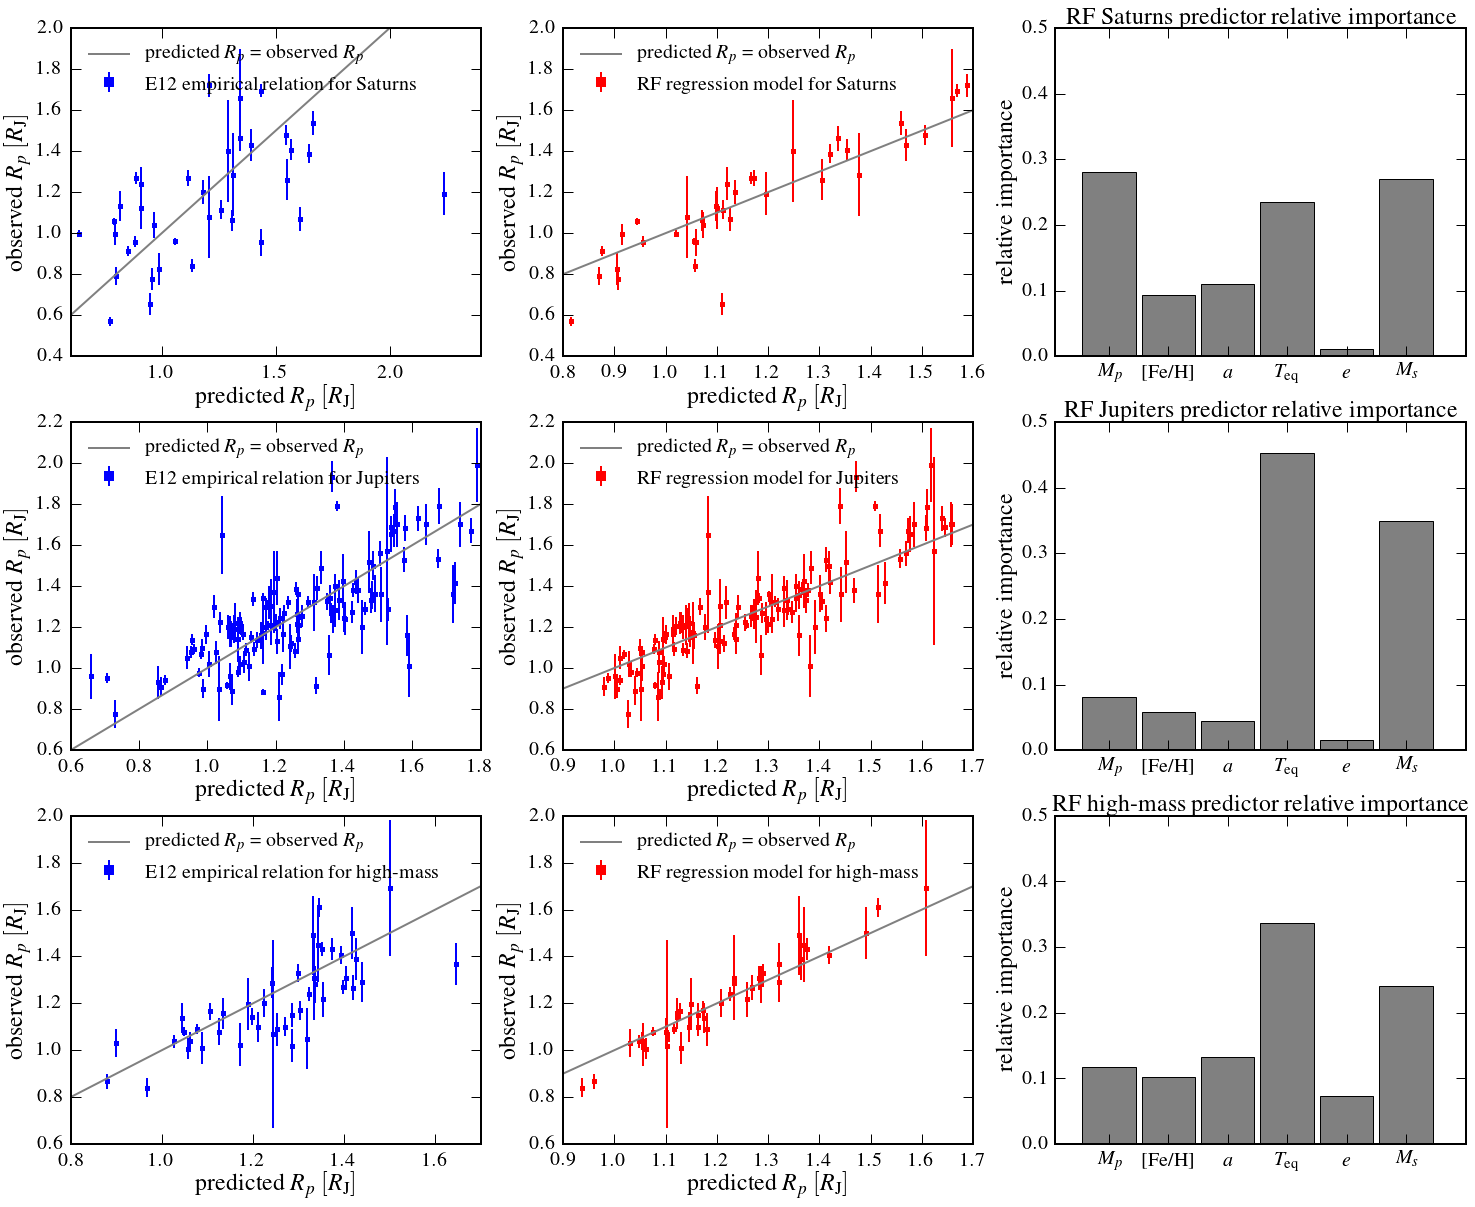

In [25]:
# MAKE THE PLOTS
fig = plt.figure(figsize=(25,20))

# fonts for the entire thing
matplotlib.rcParams['font.size'] = 20

# lines
matplotlib.rcParams['lines.linewidth'] = 2.0

# axes
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.labelsize'] = 'large'

# ticks
matplotlib.rcParams['xtick.major.size'] = 10.0
matplotlib.rcParams['xtick.minor.size'] = 5.0
matplotlib.rcParams['xtick.major.width'] = 1.0
matplotlib.rcParams['xtick.minor.width'] = 1.0
matplotlib.rcParams['xtick.major.pad'] = 8.0

matplotlib.rcParams['ytick.major.size'] = 10.0
matplotlib.rcParams['ytick.minor.size'] = 5.0
matplotlib.rcParams['ytick.major.width'] = 1.0
matplotlib.rcParams['ytick.minor.width'] = 1.0
matplotlib.rcParams['ytick.major.pad'] = 8.0

# legend
matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['legend.fontsize'] = 'medium'
matplotlib.rcParams['legend.frameon'] = False
matplotlib.rcParams['legend.markerscale'] = 2.0

features = np.array(['$M_{p}$', '[Fe/H]', '$a$', '$T_{\mathrm{eq}}$', '$e$','$M_s$'])

## SATURNS
plt.subplot(3,3,1)
plt.errorbar(10.0**modelsatrad,satradii,yerr=satradiierrs,
             markersize=5,capsize=0,ecolor='blue',elinewidth=2.0,linestyle='none',markeredgewidth=0,
             color='blue',marker='s',label='E12 empirical relation for Saturns')
xl = plt.xlim()
yl = plt.ylim()
plt.xlim(xl)
plt.ylim(yl)
plt.plot(np.linspace(-5,5),np.linspace(-5,5),color='gray',label='predicted $R_p$ = observed $R_p$')
plt.legend(scatterpoints=1,loc='upper left')
plt.xlabel('predicted $R_p$ $[R_{\mathrm{J}}]$')
plt.ylabel('observed $R_p$ $[R_{\mathrm{J}}]$')

plt.subplot(3,3,2)
plt.errorbar(sat_predicted,saty,yerr=satradiierrs,
            markersize=5,capsize=0,ecolor='red',elinewidth=2.0,linestyle='none',markeredgewidth=0,
            color='red',marker='s',
            label='RF regression model for Saturns')
xl = plt.xlim()
yl = plt.ylim()
plt.xlim(xl)
plt.ylim(yl)
plt.plot(np.linspace(-5,5),np.linspace(-5,5),color='gray',label='predicted $R_p$ = observed $R_p$')
print 'Saturns MAE, R^2: ', median_absolute_error(saty, sat_predicted), r2_score(saty, sat_predicted)
plt.legend(scatterpoints=1,loc='upper left')
plt.xlabel('predicted $R_p$ $[R_{\mathrm{J}}]$')
plt.ylabel('observed $R_p$ $[R_{\mathrm{J}}]$')

plt.subplot(3,3,3)
plt.bar([0,1,2,3,4,5],sat_importance,width=0.9,
        color='grey')
plt.xticks([0.45,1.45,2.45,3.45,4.45,5.45],features)
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.xlim(-0.45,6.45)
plt.ylim(0.0,0.5)
plt.ylabel('relative importance')
plt.title('RF Saturns predictor relative importance')

## JUPITERS ##
plt.subplot(3,3,4)
plt.errorbar(10.0**modeljuprad,jupradii,yerr=jupradiierrs,
             markersize=5,capsize=0,ecolor='blue',elinewidth=2.0,linestyle='none',markeredgewidth=0,
             color='blue',marker='s',label='E12 empirical relation for Jupiters')
xl = plt.xlim()
yl = plt.ylim()
plt.xlim(xl)
plt.ylim(yl)
plt.plot(np.linspace(-5,5),np.linspace(-5,5),color='gray',label='predicted $R_p$ = observed $R_p$')
plt.legend(scatterpoints=1,loc='upper left')
plt.xlabel('predicted $R_p$ $[R_{\mathrm{J}}]$')
plt.ylabel('observed $R_p$ $[R_{\mathrm{J}}]$')

plt.subplot(3,3,5)
plt.errorbar(jup_predicted,jupy,yerr=jupradiierrs,
            markersize=5,capsize=0,ecolor='red',elinewidth=2.0,linestyle='none',markeredgewidth=0,
            color='red',marker='s',
            label='RF regression model for Jupiters')
xl = plt.xlim()
yl = plt.ylim()
plt.xlim(xl)
plt.ylim(yl)
plt.plot(np.linspace(-5,5),np.linspace(-5,5),color='gray',label='predicted $R_p$ = observed $R_p$')
e12_rscore = r2_score(jupy, jup_predicted)
print 'Jupiters MAE, R2: ', median_absolute_error(jupy, jup_predicted), r2_score(jupy, jup_predicted)
plt.legend(scatterpoints=1,loc='upper left')
plt.xlabel('predicted $R_p$ $[R_{\mathrm{J}}]$')
plt.ylabel('observed $R_p$ $[R_{\mathrm{J}}]$')

plt.subplot(3,3,6)
plt.bar([0,1,2,3,4,5],jup_importance,width=0.9,
        color='grey')
plt.xticks([0.45,1.45,2.45,3.45,4.45,5.45],features)
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.xlim(-0.45,6.45)
plt.ylim(0.0,0.5)
plt.ylabel('relative importance')
plt.title('RF Jupiters predictor relative importance')


## HI-MASS
plt.subplot(3,3,7)
plt.errorbar(10.0**modelhirad,hipradii,yerr=hipradiierrs,
             markersize=5,capsize=0,ecolor='blue',elinewidth=2.0,linestyle='none',markeredgewidth=0,
             color='blue',marker='s',label='E12 empirical relation for high-mass')
xl = plt.xlim()
yl = plt.ylim()
plt.xlim(xl)
plt.ylim(yl)
plt.plot(np.linspace(-5,5),np.linspace(-5,5),color='gray',label='predicted $R_p$ = observed $R_p$')
plt.legend(scatterpoints=1,loc='upper left')
plt.xlabel('predicted $R_p$ $[R_{\mathrm{J}}]$')
plt.ylabel('observed $R_p$ $[R_{\mathrm{J}}]$')

plt.subplot(3,3,8)
plt.errorbar(hip_predicted,hipy,yerr=hipradiierrs,
            markersize=5,capsize=0,ecolor='red',elinewidth=2.0,linestyle='none',markeredgewidth=0,
            color='red',marker='s',
            label='RF regression model for high-mass')
xl = plt.xlim()
yl = plt.ylim()
plt.xlim(xl)
plt.ylim(yl)
plt.plot(np.linspace(-5,5),np.linspace(-5,5),color='gray',label='predicted $R_p$ = observed $R_p$')
print 'high-mass MAE, R2: ', median_absolute_error(hipy, hip_predicted), r2_score(hipy, hip_predicted)
plt.legend(scatterpoints=1,loc='upper left')
plt.xlabel('predicted $R_p$ $[R_{\mathrm{J}}]$')
plt.ylabel('observed $R_p$ $[R_{\mathrm{J}}]$')

plt.subplot(3,3,9)
plt.bar([0,1,2,3,4,5],hip_importance,width=0.9,
        color='grey')
plt.xticks([0.45,1.45,2.45,3.45,4.45,5.45],features)
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.xlim(-0.45,6.45)
plt.ylim(0.0,0.5)
plt.ylabel('relative importance')
plt.title('RF high-mass predictor relative importance')

plt.savefig("rfr-radius-model.pdf",bbox_inches='tight')